# STDFT - Kratkočasovna diskretna fourierjeva transformacija (ST-DFT)

In [1]:
from scipy.io.wavfile import read
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def compute_stdft(signal, sample_rate, window_ms, overlap_ratio, window_fn):
    window_len = int((window_ms / 1000) * sample_rate)
    hop_size = int(window_len * (1 - overlap_ratio))

    window = window_fn(window_len)

    # Računanje števila frame-ov in dopolnitev z ničlami (padding)
    num_frames = int(np.ceil((len(signal) - window_len) / hop_size)) + 1
    total_len = hop_size * (num_frames - 1) + window_len
    padded_signal = np.pad(signal, (0, total_len - len(signal)), mode='constant')

    stft_result = []

    for i in range(num_frames):
        start = i * hop_size
        end = start + window_len
        frame = padded_signal[start:end] * window
        spectrum = np.fft.fft(frame)
        stft_result.append(np.abs(spectrum[:window_len // 2]))

    stft_matrix = np.array(stft_result).T  # shape: [freq, times]

    freqs = np.fft.fftfreq(window_len, d=1 / sample_rate)[:window_len // 2]
    times = np.arange(num_frames) * hop_size / sample_rate

    return freqs, times, stft_matrix

In [3]:
def plot_stft_section(filename, stft_results, window_ms):
    overlap_ratios = sorted(set(r['overlap'] for r in stft_results if r['window_ms'] == window_ms))
    window_names = sorted(set(r['window_name'] for r in stft_results if r['window_ms'] == window_ms))

    fig, axes = plt.subplots(
        2, 3, figsize=(18, 8), sharex=True, sharey=True, constrained_layout=True
    )
    fig.suptitle(f"{filename} - Window size: {window_ms} ms", fontsize=18)

    pcm = None  # will save last mesh for colorbar

    for row_idx, window_name in enumerate(window_names):
        for col_idx, overlap in enumerate(overlap_ratios):
            ax = axes[row_idx, col_idx]

            # Find the corresponding STFT result
            res = next(r for r in stft_results
                       if r['window_ms'] == window_ms
                       and r['overlap'] == overlap
                       and r['window_name'] == window_name)

            if res['matrix'].size > 0:
                pcm = ax.pcolormesh(
                    res['times'], res['freqs'], np.abs(res['matrix']),
                    shading='auto', cmap='jet'
                )
                ax.set_ylim(0, 2000)
                ax.set_aspect('auto')

            # Axis labels
            ax.set_xlabel("Time (s)")
            ax.set_ylabel("Frequency (Hz)", rotation=90)

            # Column headers (overlap)
            if row_idx == 0:
                ax.set_title(f"Overlap {overlap}%")

            # Row labels (window name)
            if col_idx == 0:
                ax.annotate(
                    window_name, xy=(0, 0.5), xycoords="axes fraction",
                    xytext=(-50, 0), textcoords="offset points",
                    va="center", ha="right", rotation=90, fontsize=12
                )

    # Shared colorbar on the right
    if pcm:
        cbar = fig.colorbar(pcm, ax=axes, format='%.1f', pad=0.02, location='right')
        cbar.set_label("Amplitude")

    plt.show()


def plot_all_sections(filename, stft_results):
    windows_ms = sorted(set(r['window_ms'] for r in stft_results))
    for w_ms in windows_ms:
        plot_stft_section(filename, stft_results, w_ms)


In [4]:
import os


def procesiraj_signale():
    folder = 'Audio'
    files = [f for f in os.listdir(folder) if f.lower().endswith('.wav')]
    windows_ms = [10, 20, 50, 100]
    overlap_ratios = [0.0, 0.5, 0.75]
    window_types = {
        "Hamming": np.hamming,
        "Rectangular": lambda N: np.ones(N)
    }

    for filename in files[:]:
        filepath = os.path.join(folder, filename)
        sample_rate, signal = read(filepath)
        y = (signal / np.max(np.abs(signal))).astype(np.float32)

        stft_results = []

        for window_ms in windows_ms:
            for overlap_ratio in overlap_ratios:
                # for window in [np.hamming, lambda N: np.ones(N)]:
                for window_name, window_func in window_types.items():
                    freqs, times, stft_matrix = compute_stdft(
                        y, sample_rate, window_ms, overlap_ratio, window_func
                    )

                    stft_results.append({
                        "freqs": freqs,
                        "times": times,
                        "matrix": stft_matrix,
                        "window_ms": window_ms,
                        "overlap": int(overlap_ratio * 100),
                        "window_name": window_name
                    })

        print("\n")
        print("---" * 10, f"Processing: {filename}", "---" * 10)
        plot_all_sections(filename, stft_results)

# procesiraj_signale()

1. Kako je nestacionarnost signalov odvisna od hitrosti izgovarjave oz. ali se optimalna izbira dolžine intervalov za DFT in stopnje njihovega prekrivanja razlikuje od hitrosti izgovarjave?

Če je govor hitri, so spremembe v signalu hitrejše. Za hitre spremembe je pametno uporabiti krajša okna, da lahko sledimo spremembam v signalu, ampak s tem izgubimo pri frekvenčni ločljivosti. Prekrivanje zvečamo pri krajših oknih, da preprečimo preskoke med segmenti.

2. Kako se z izbiro dolžine intervalov spreminja zaznava višjih harmonikov v frekvenčni sliki posameznih intervalov?

Daljše ko okno, boljša je frekvenčna ločljivost. S večjo frekvenčno ločljivostjo lahko zajamemo boljšo sliko harmonikov. pri krajših oknih se ti karmoniki zlijejo skupaj




------------------------------ Processing: A_1.wav ------------------------------


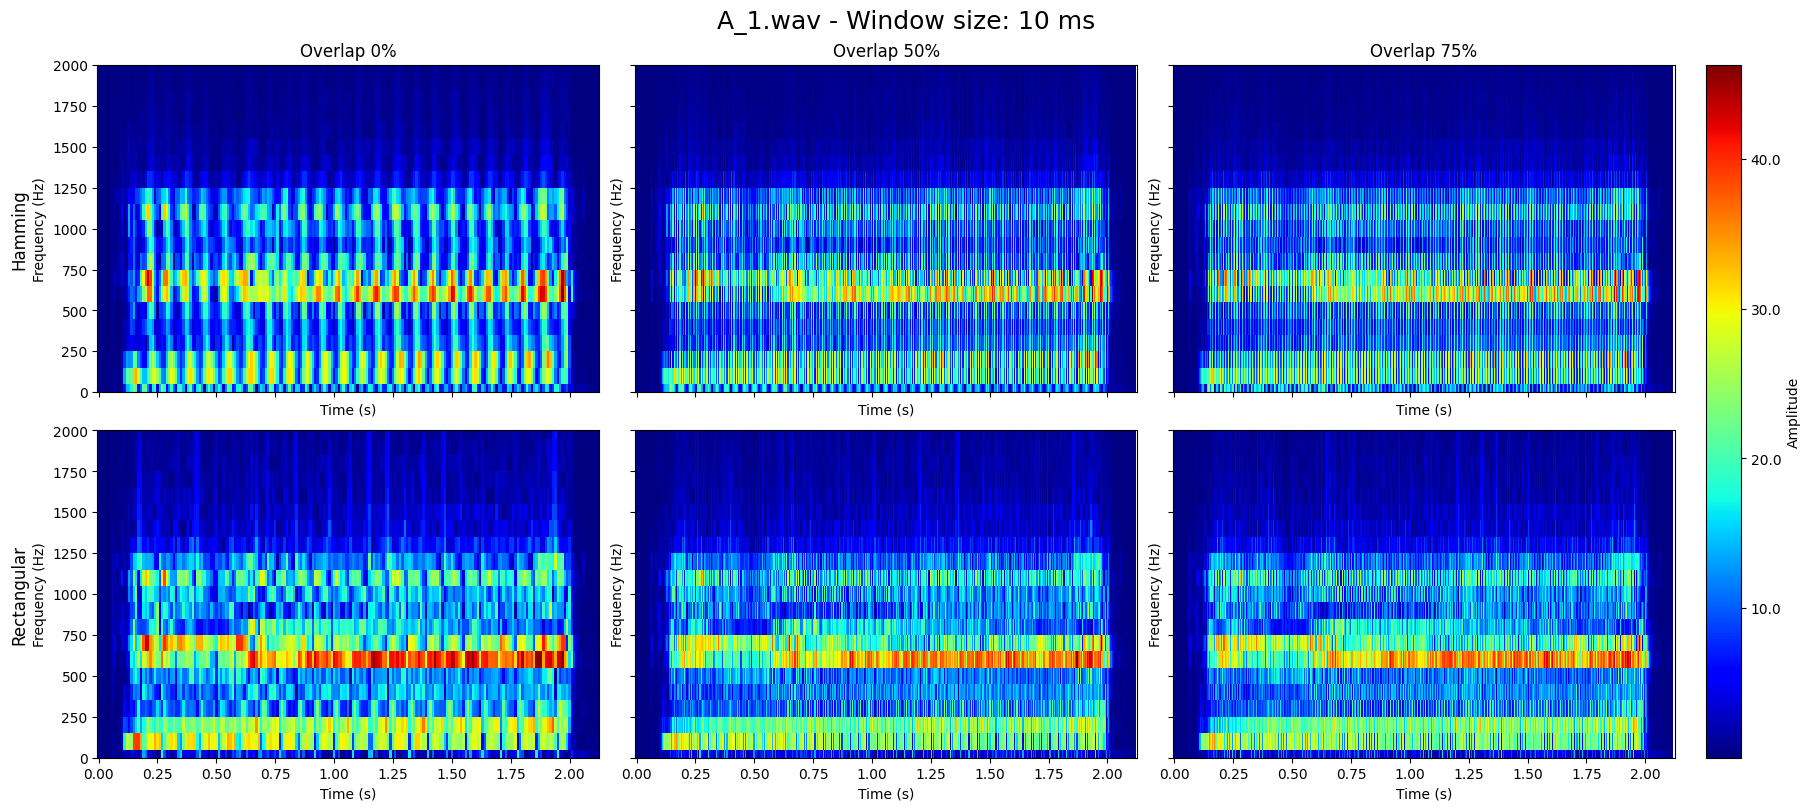

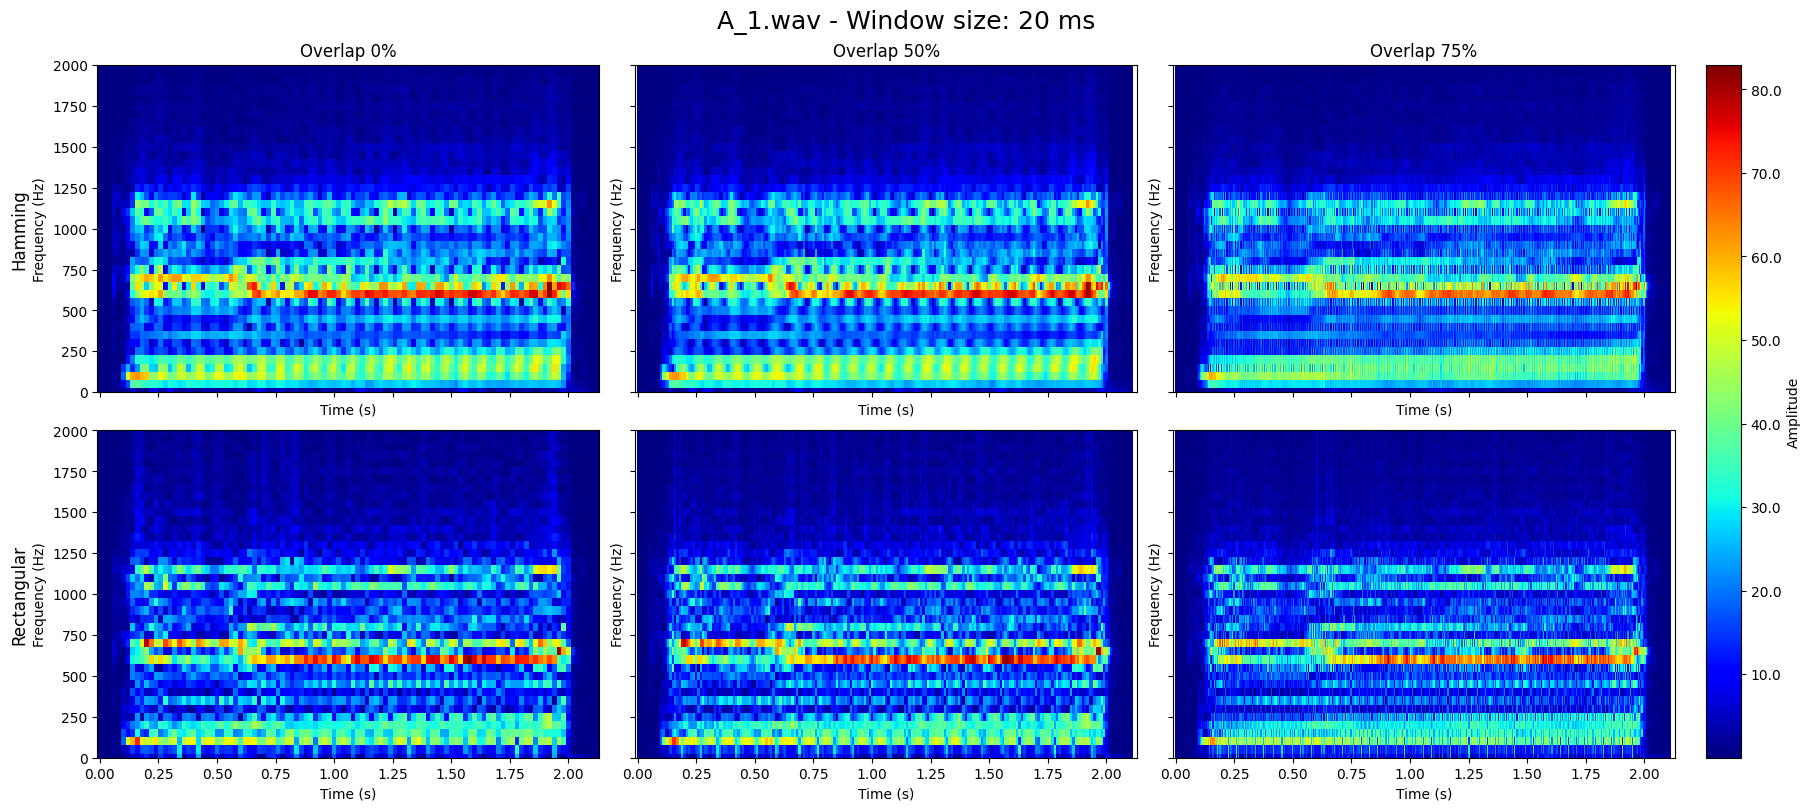

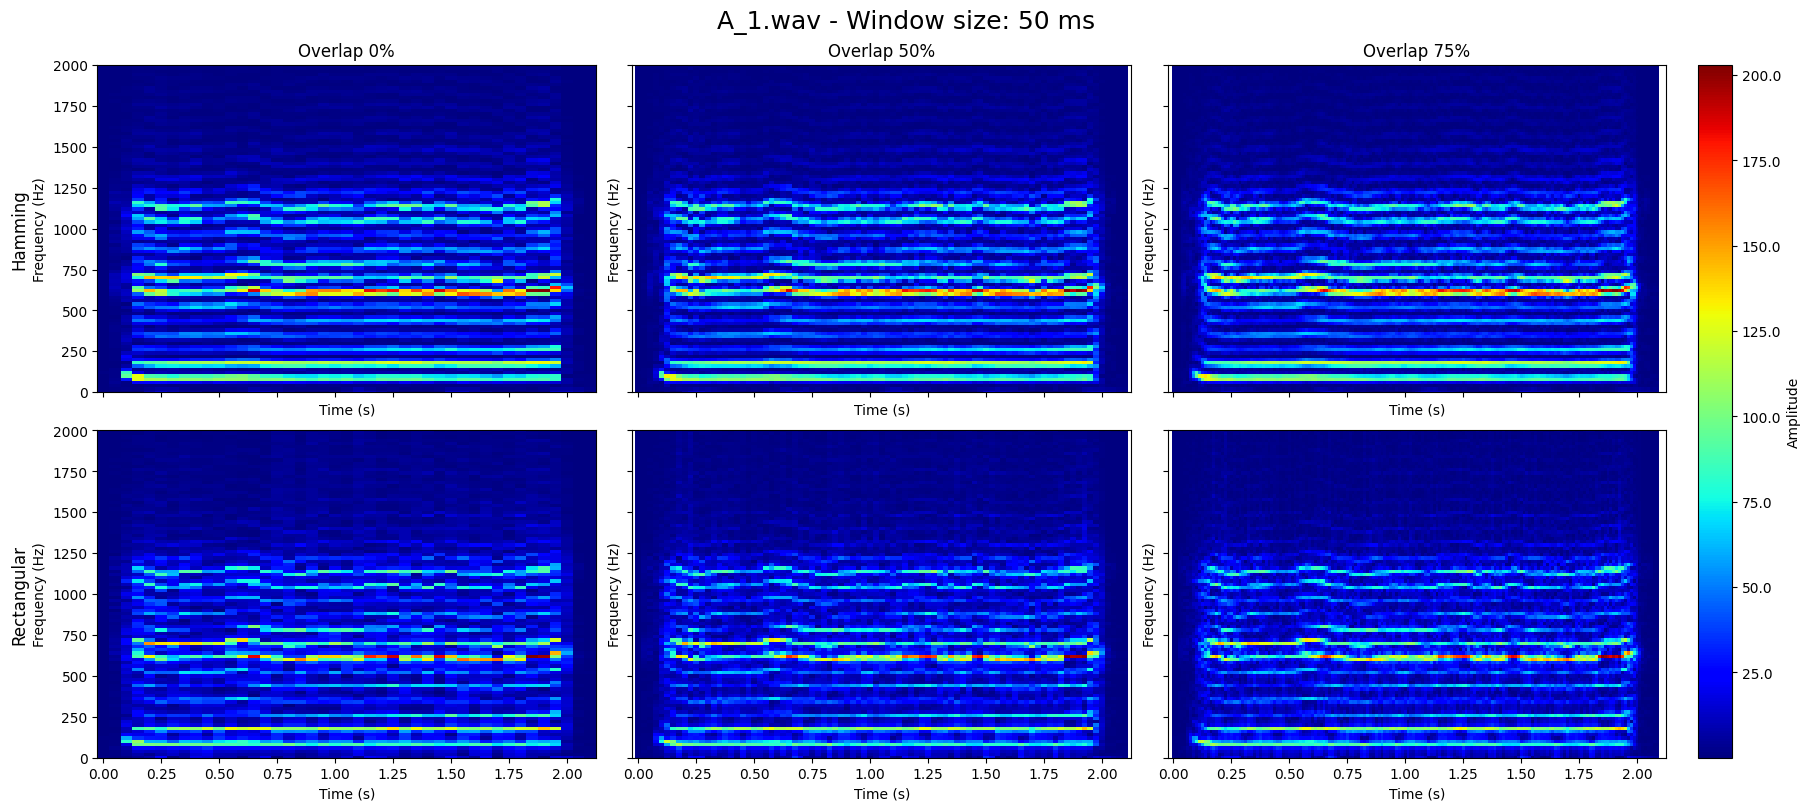

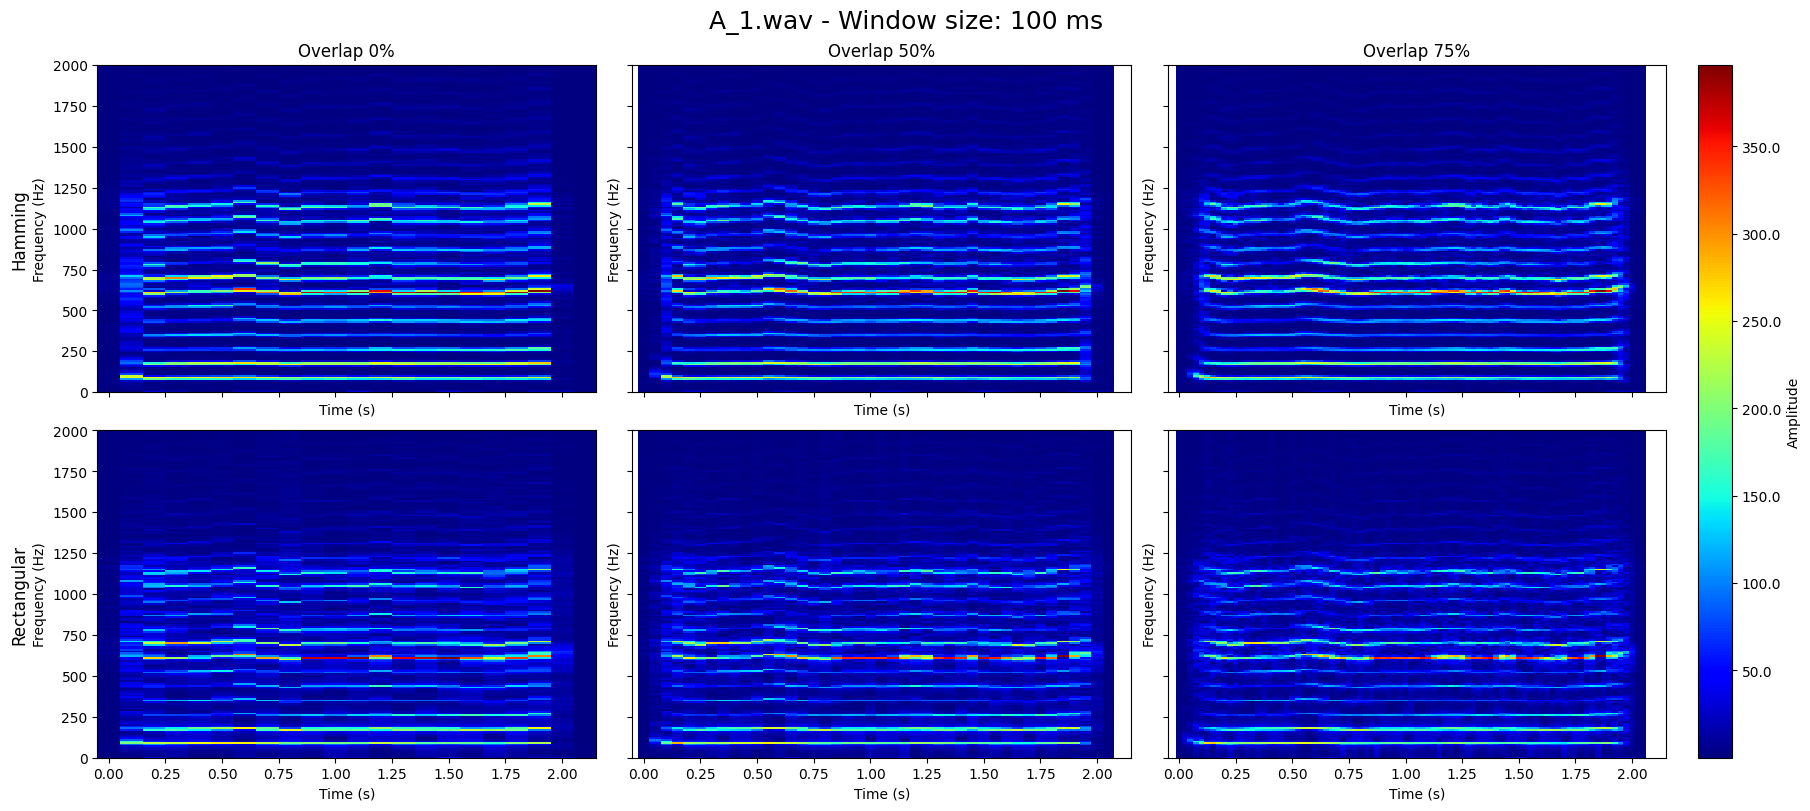



------------------------------ Processing: A_2.wav ------------------------------


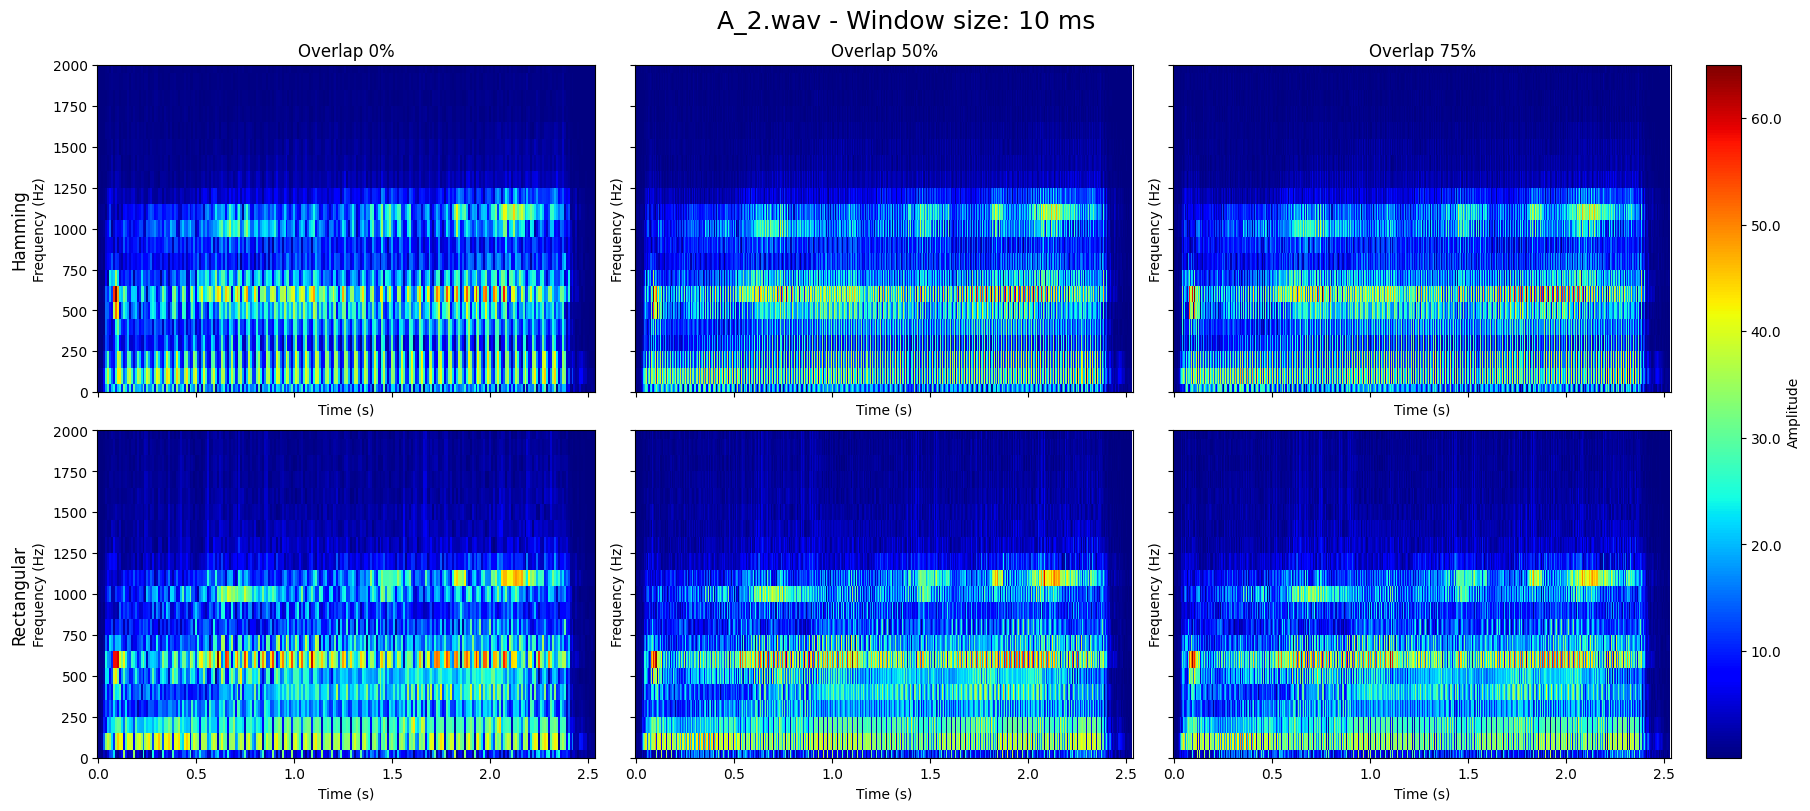

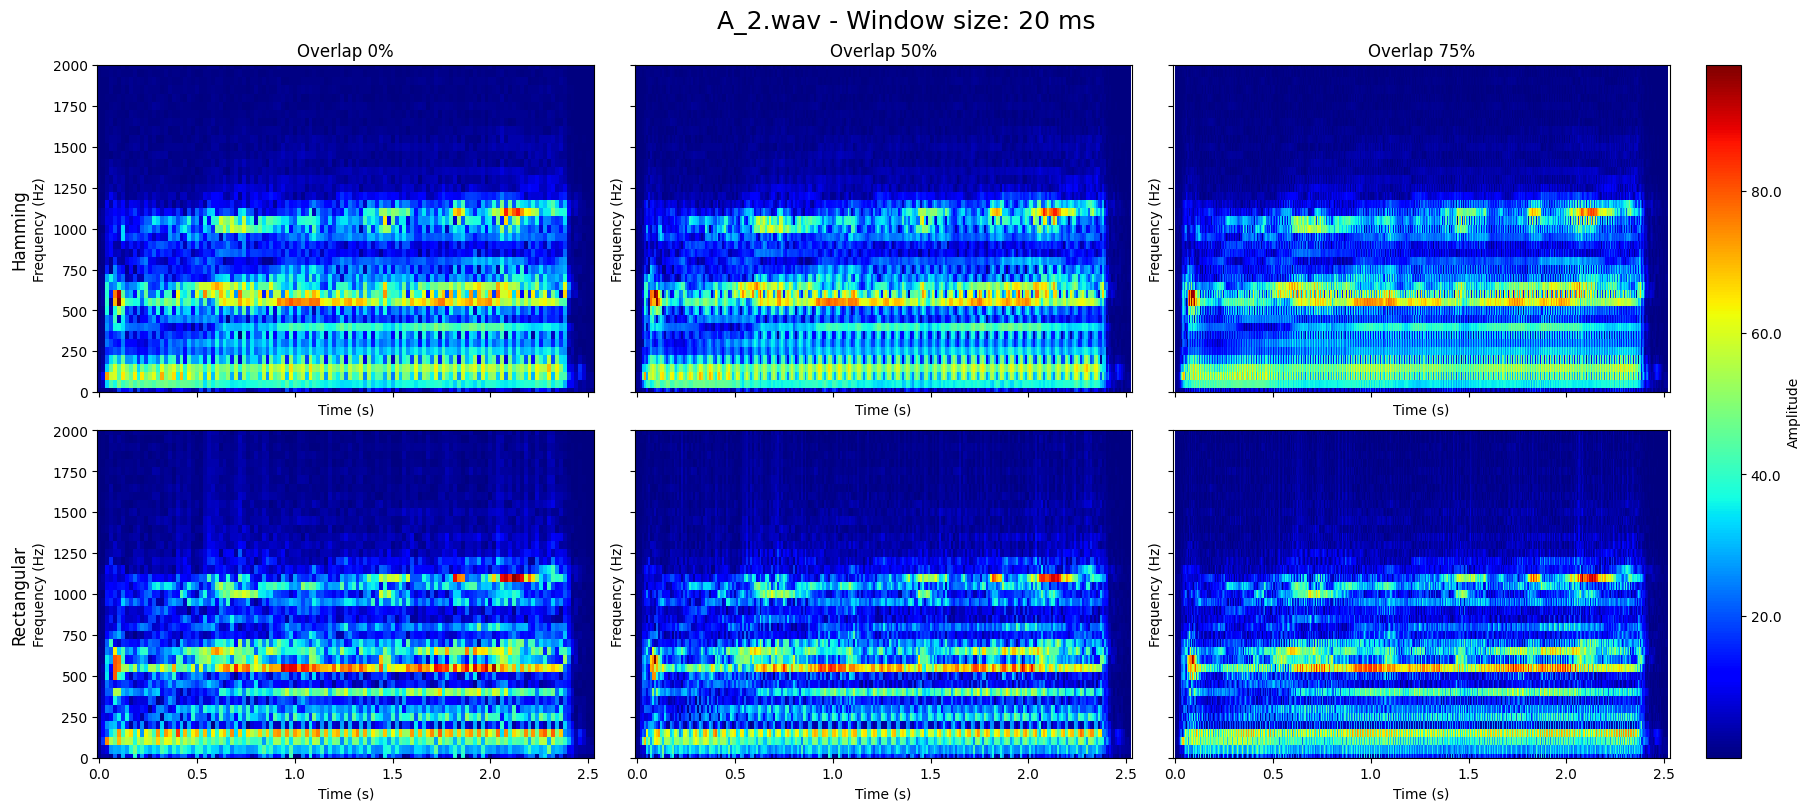

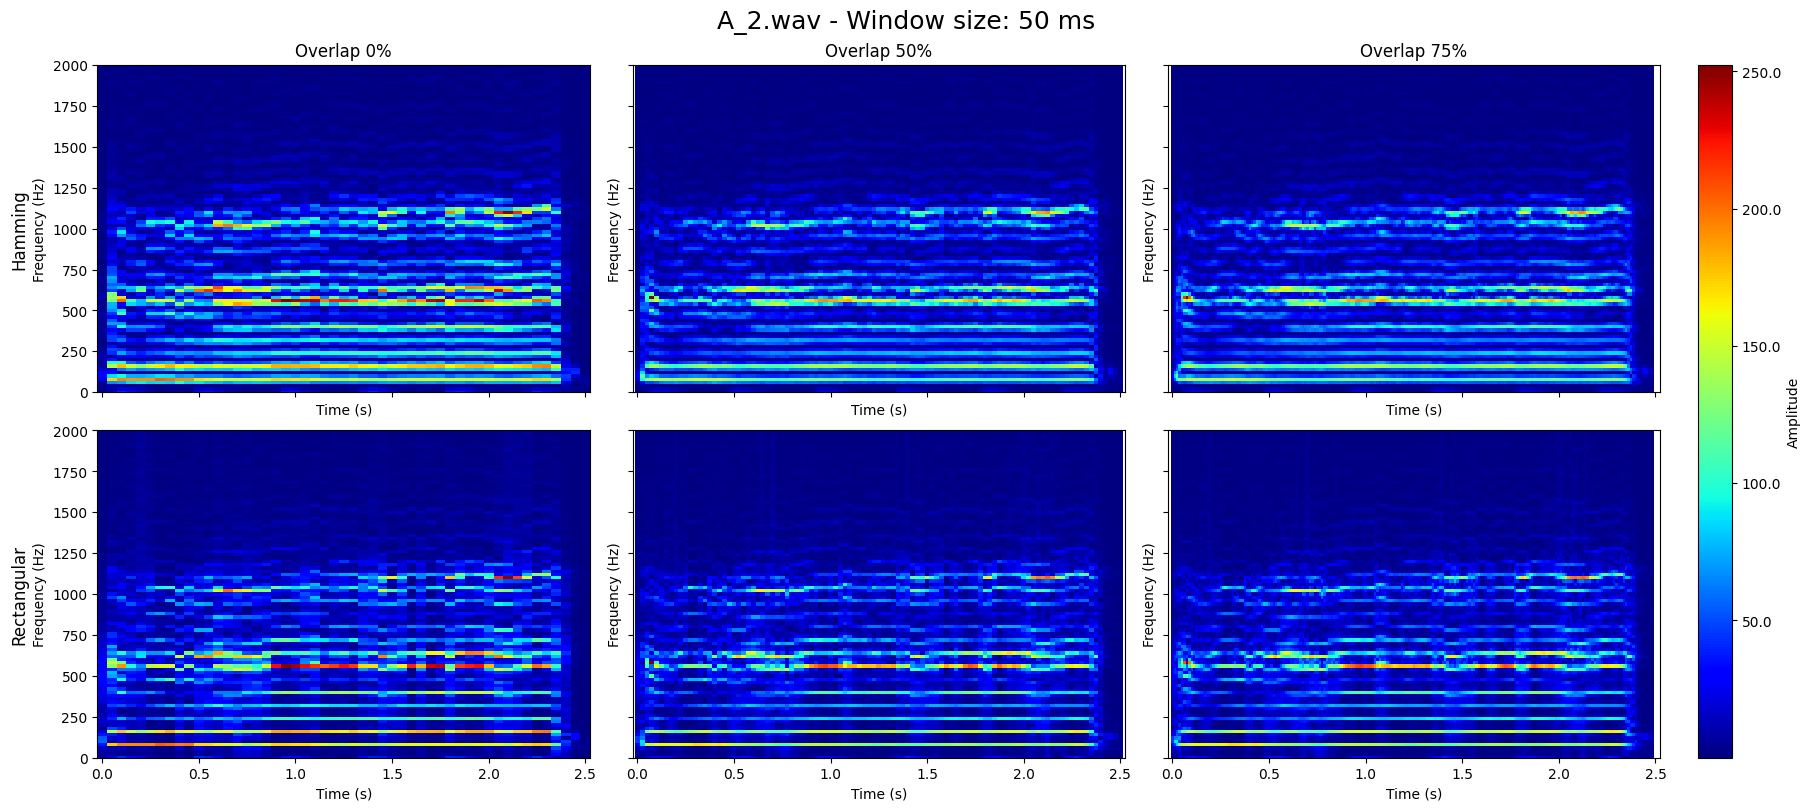

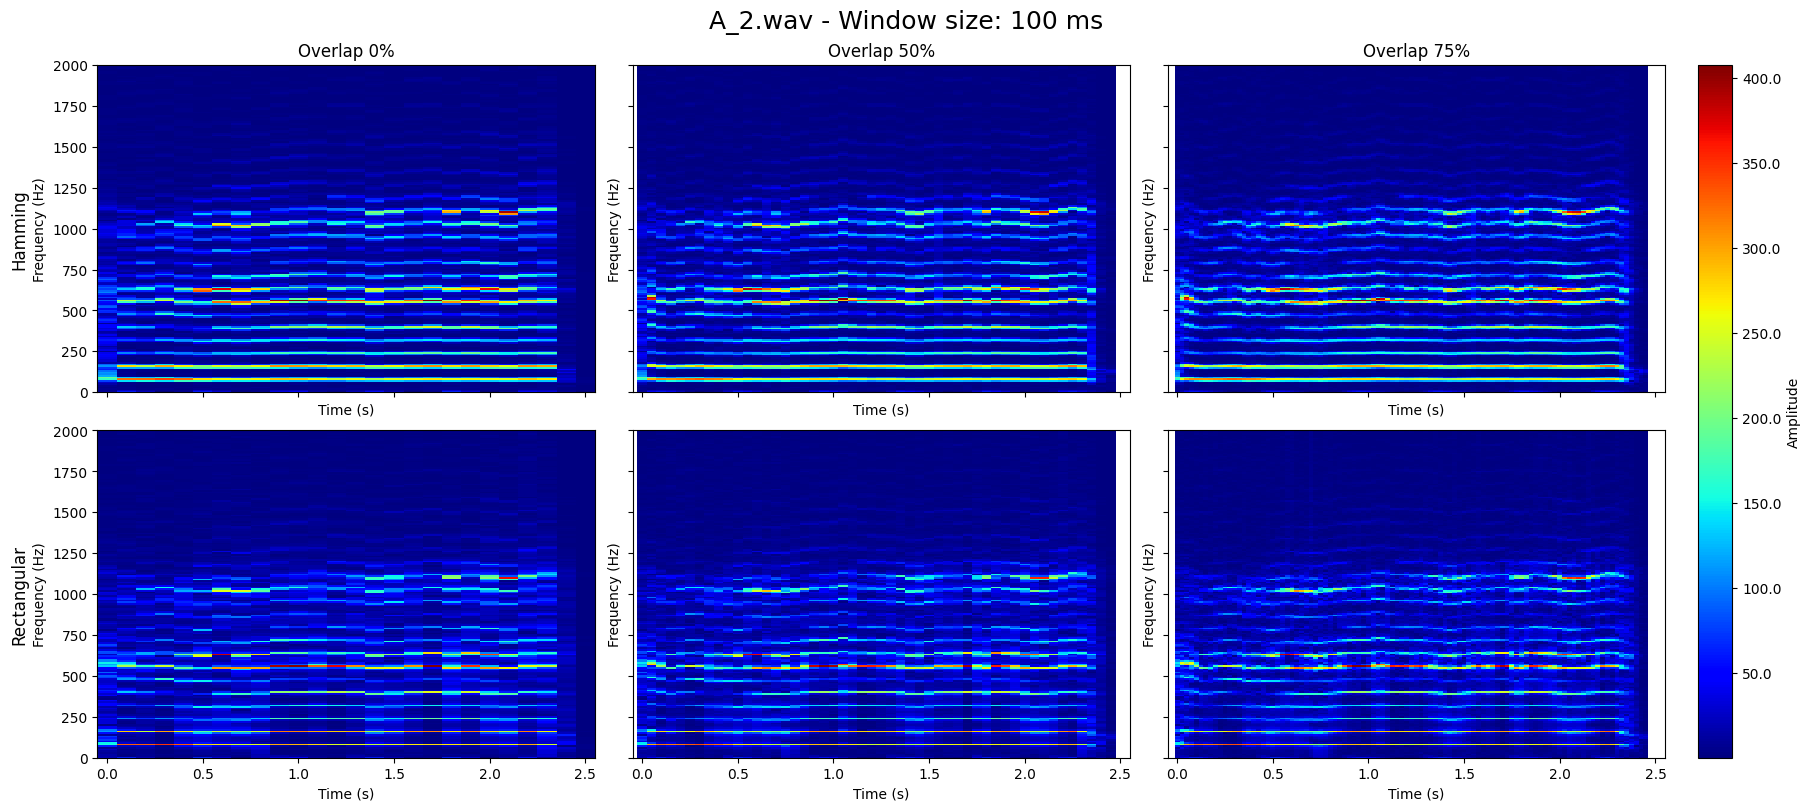



------------------------------ Processing: erozija1.wav ------------------------------


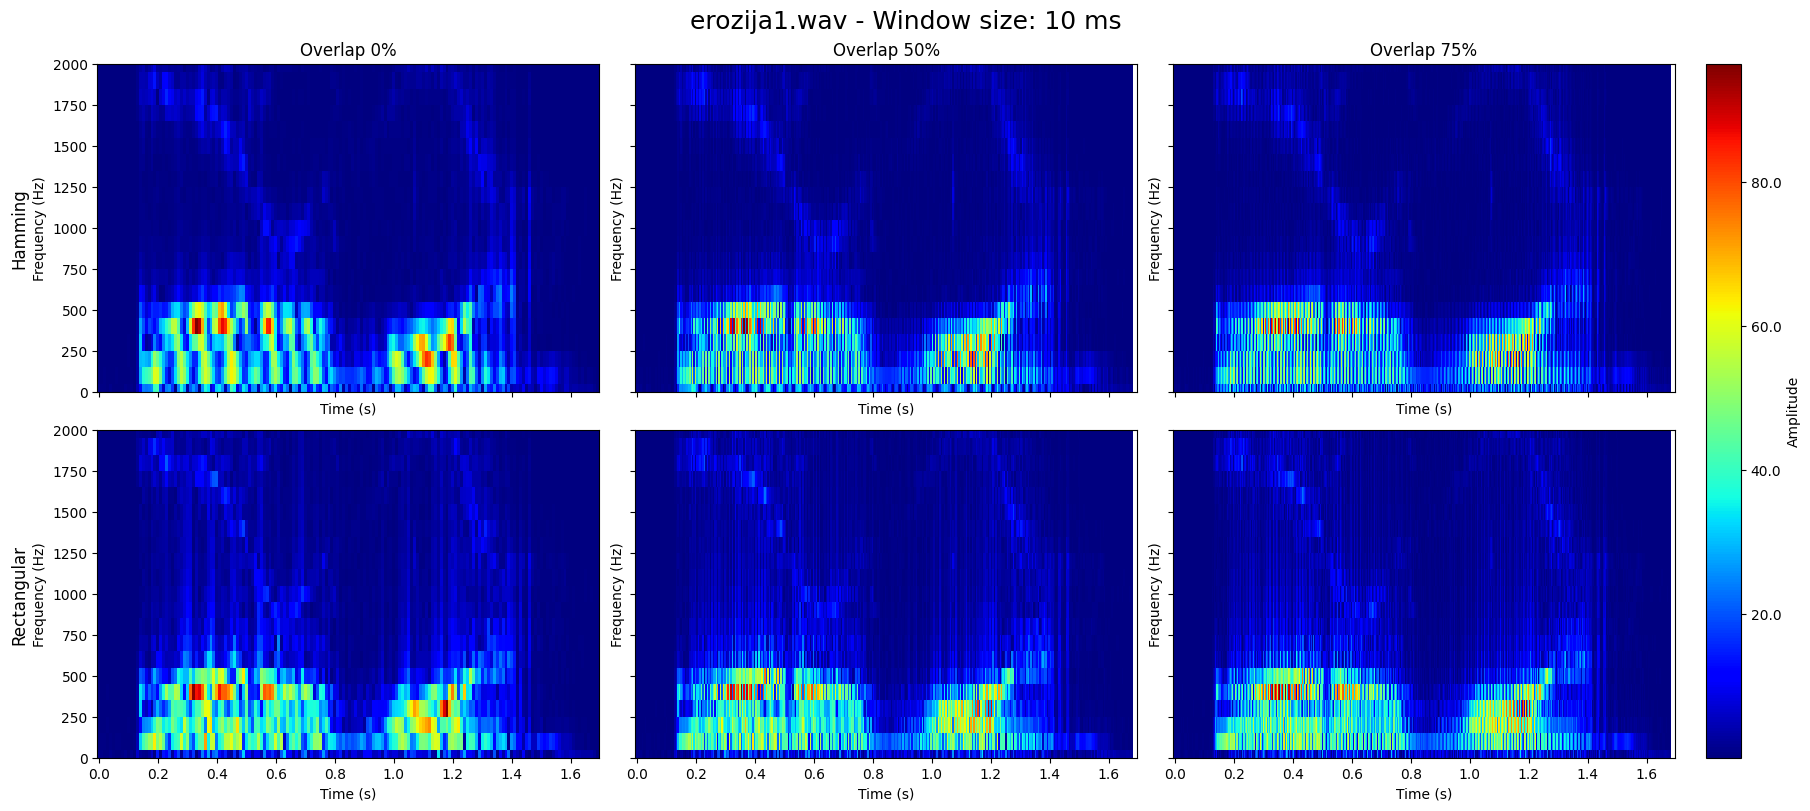

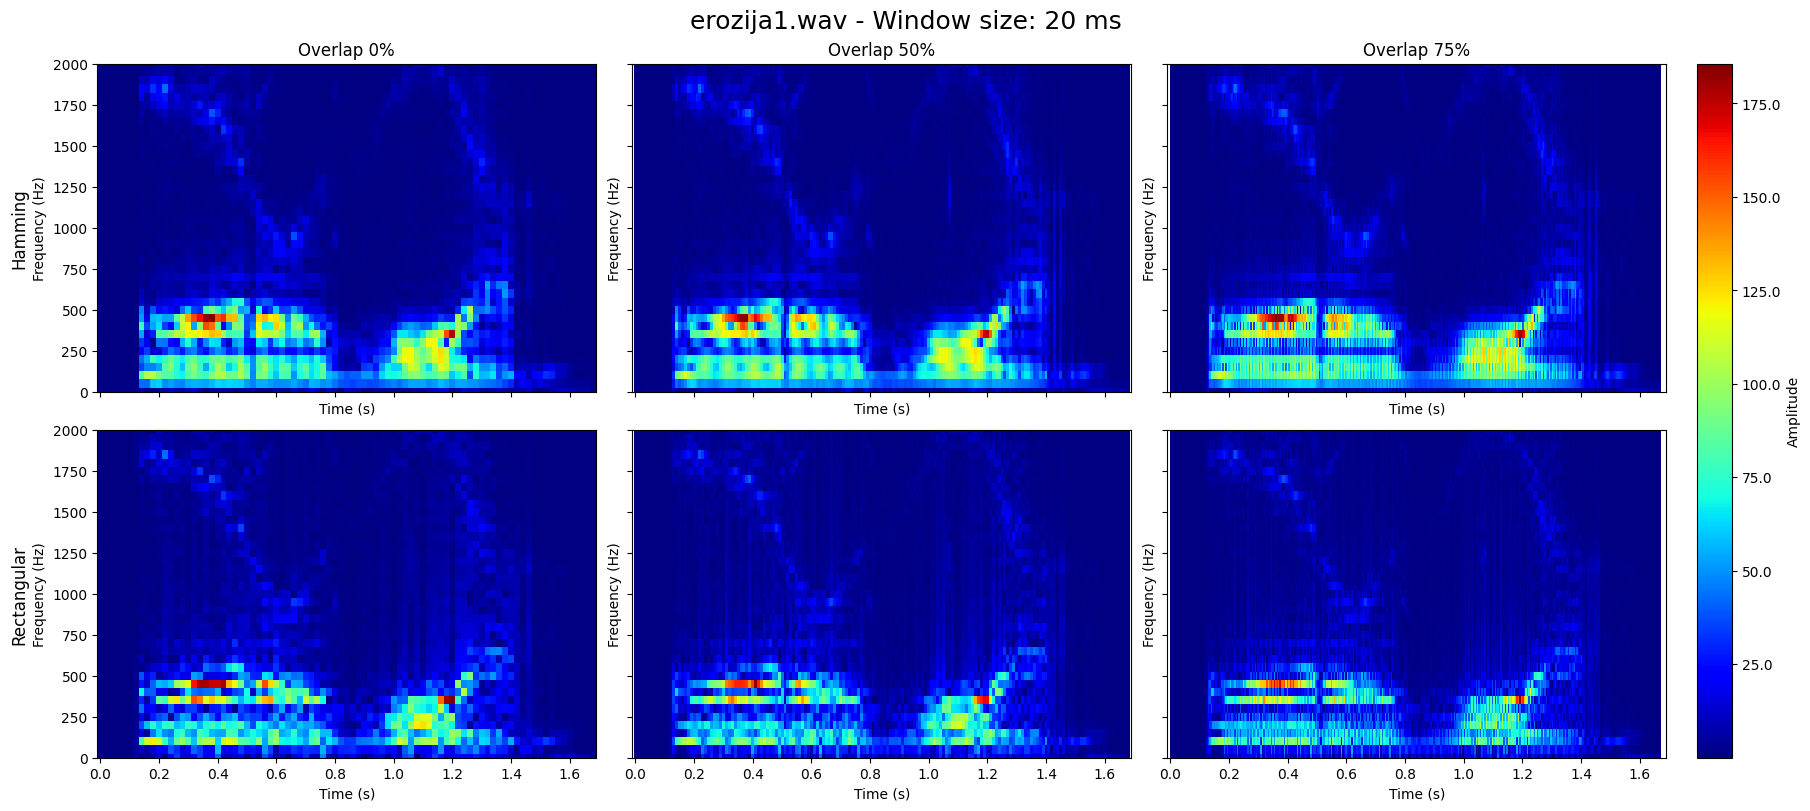

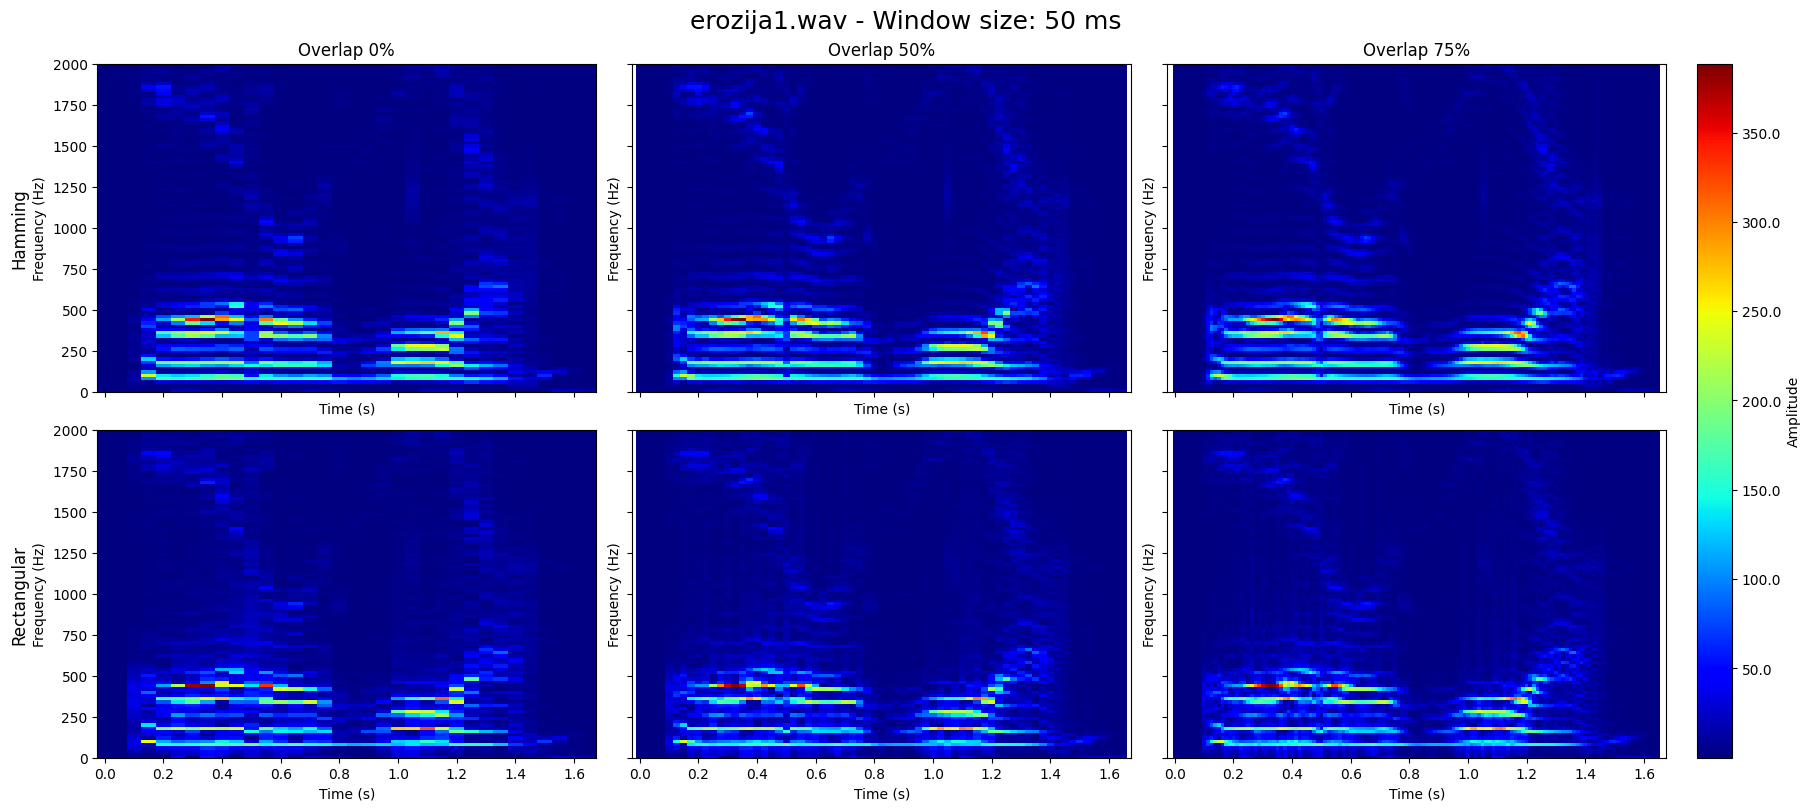

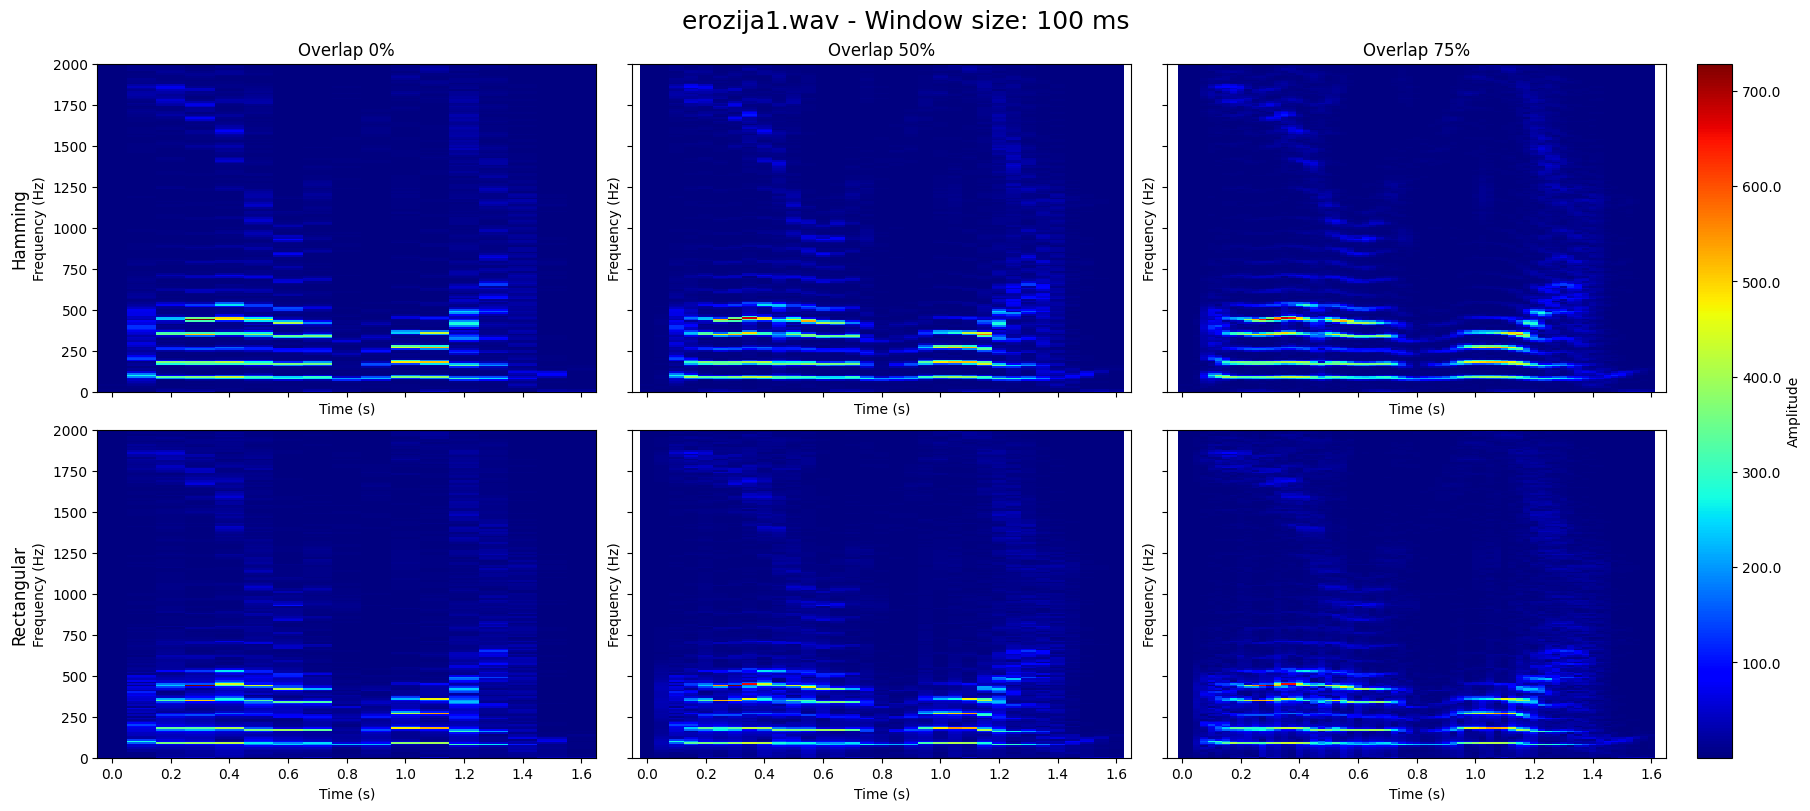



------------------------------ Processing: erozija2.wav ------------------------------


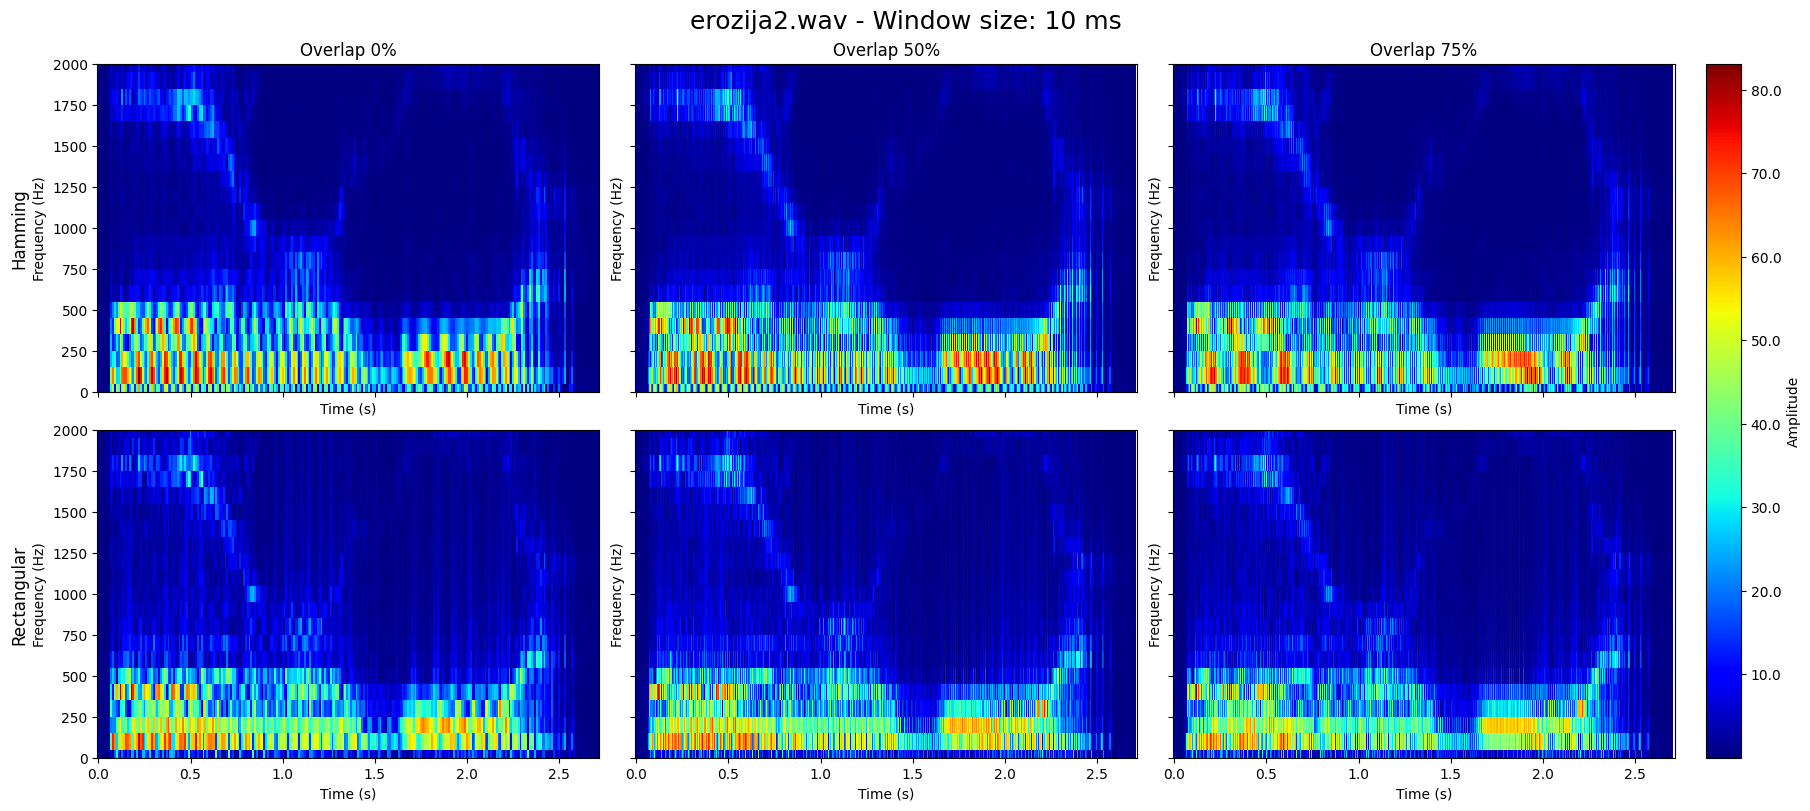

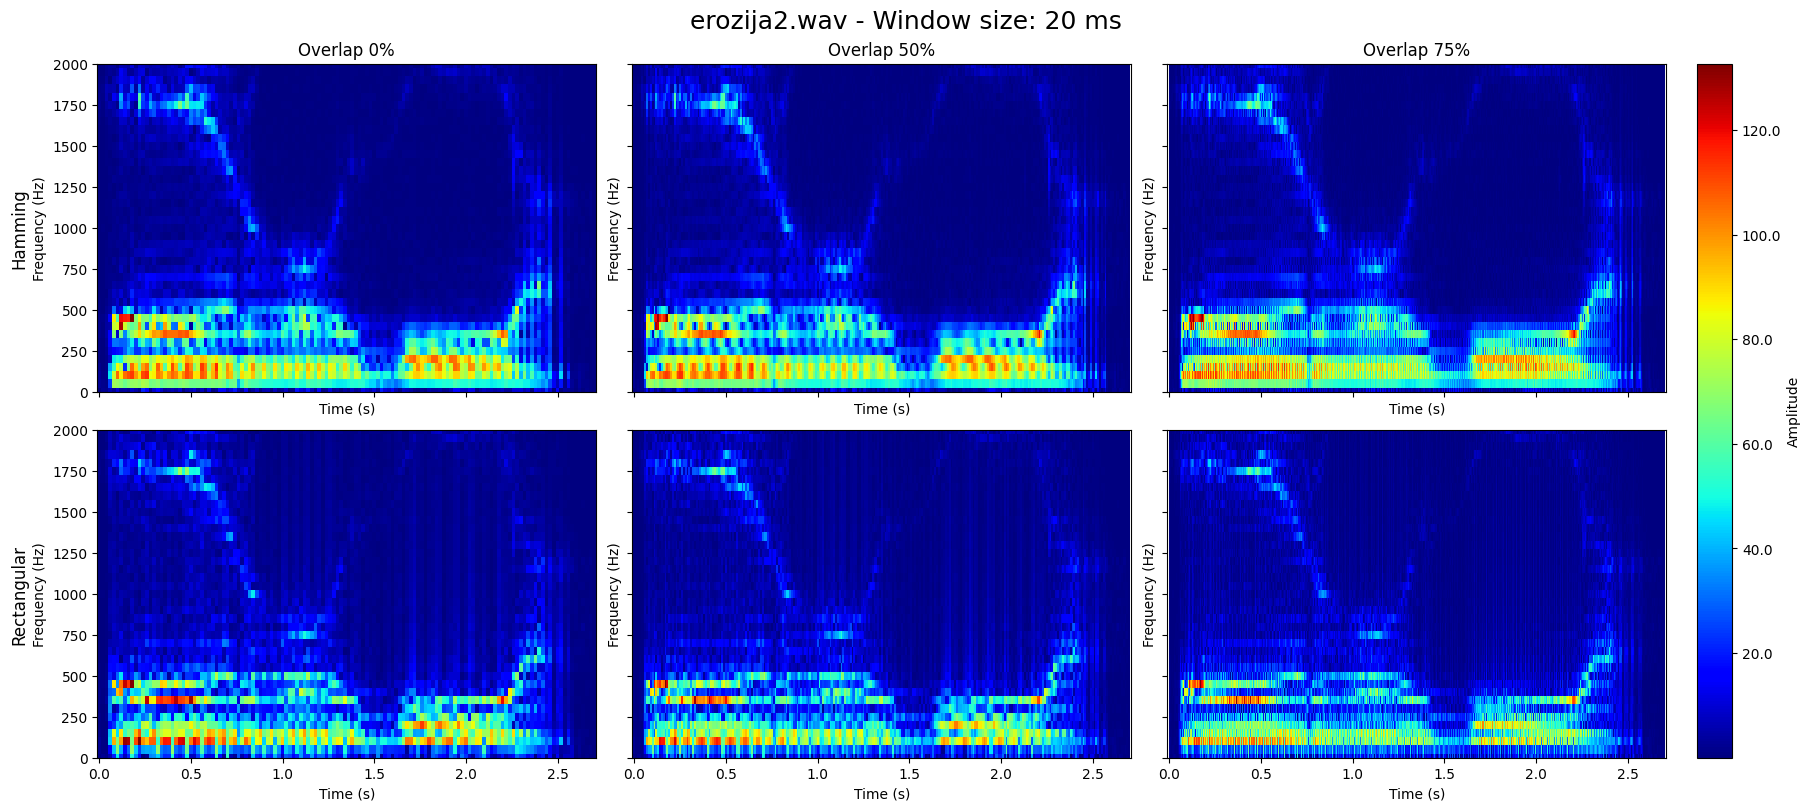

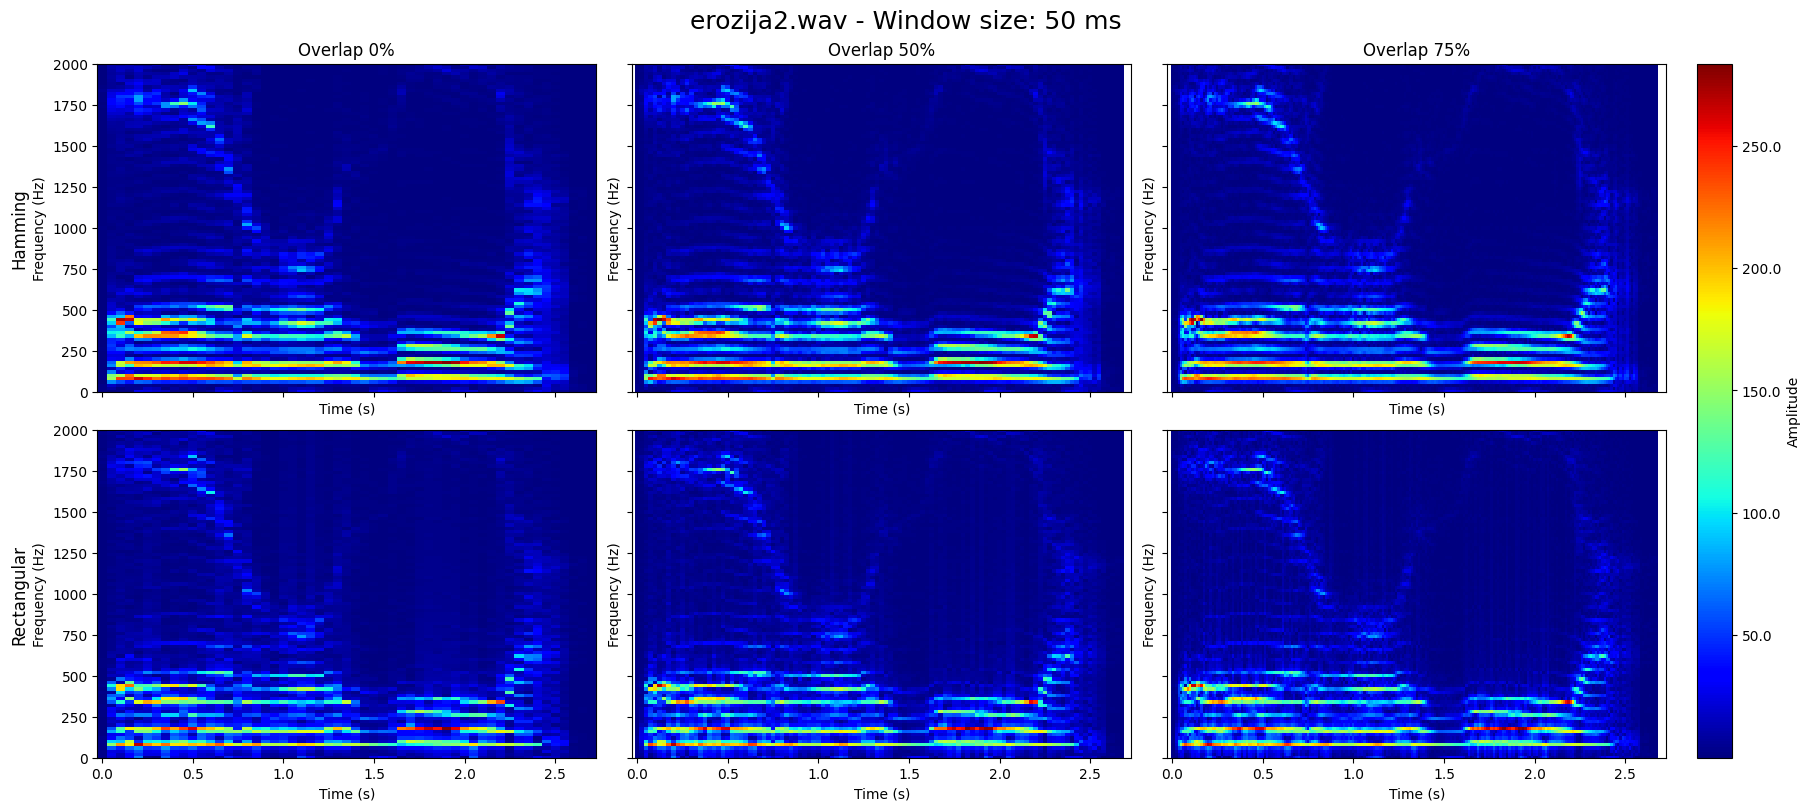

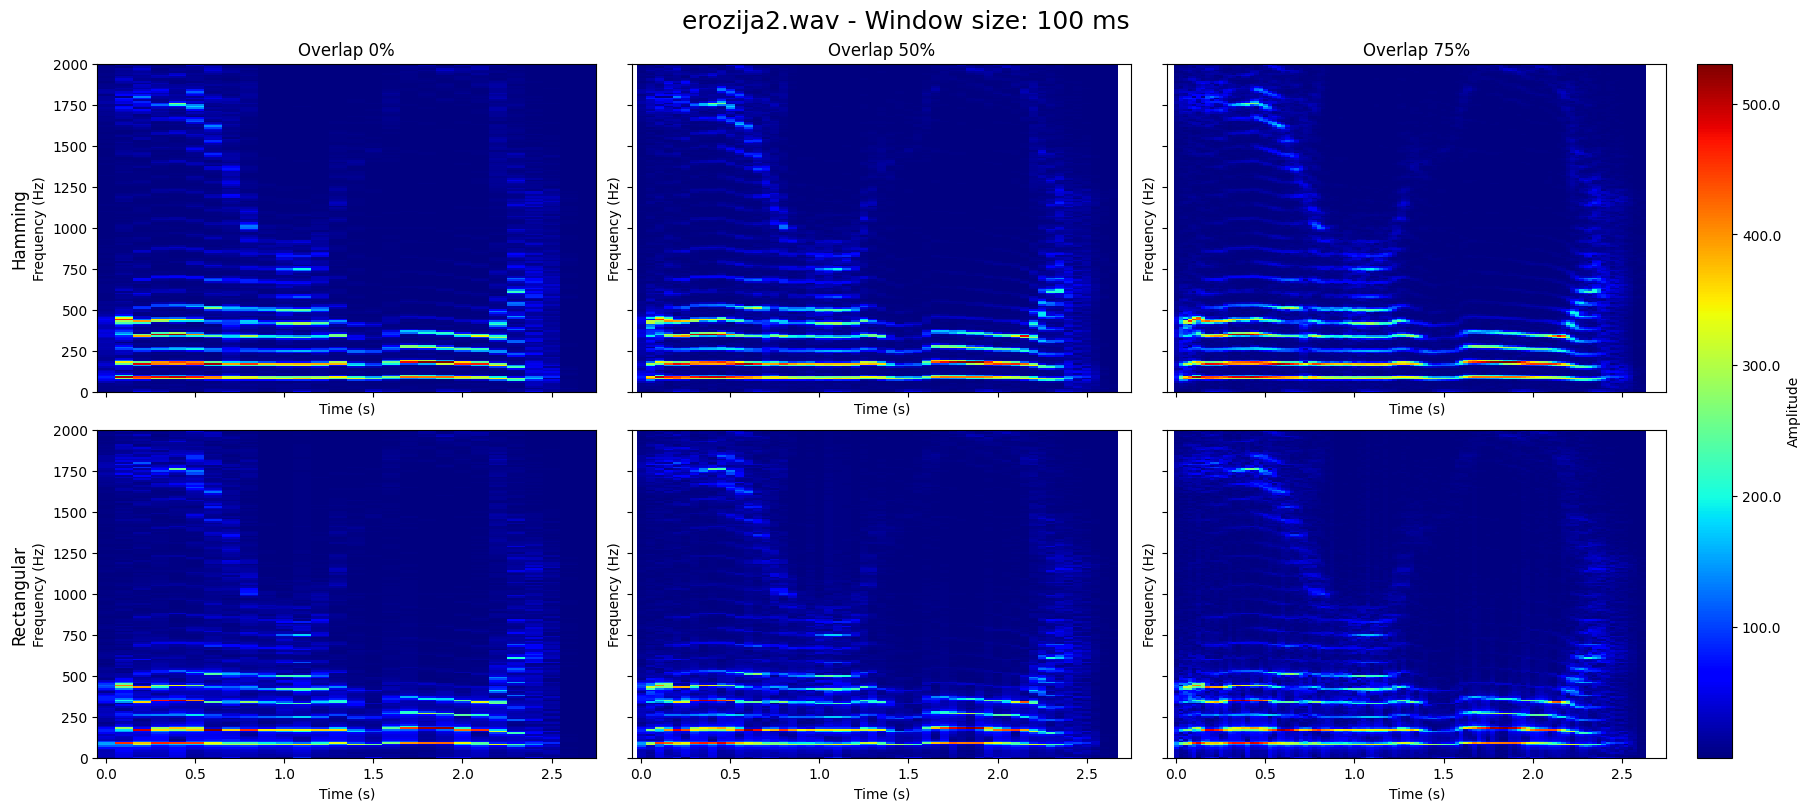



------------------------------ Processing: I_1.wav ------------------------------


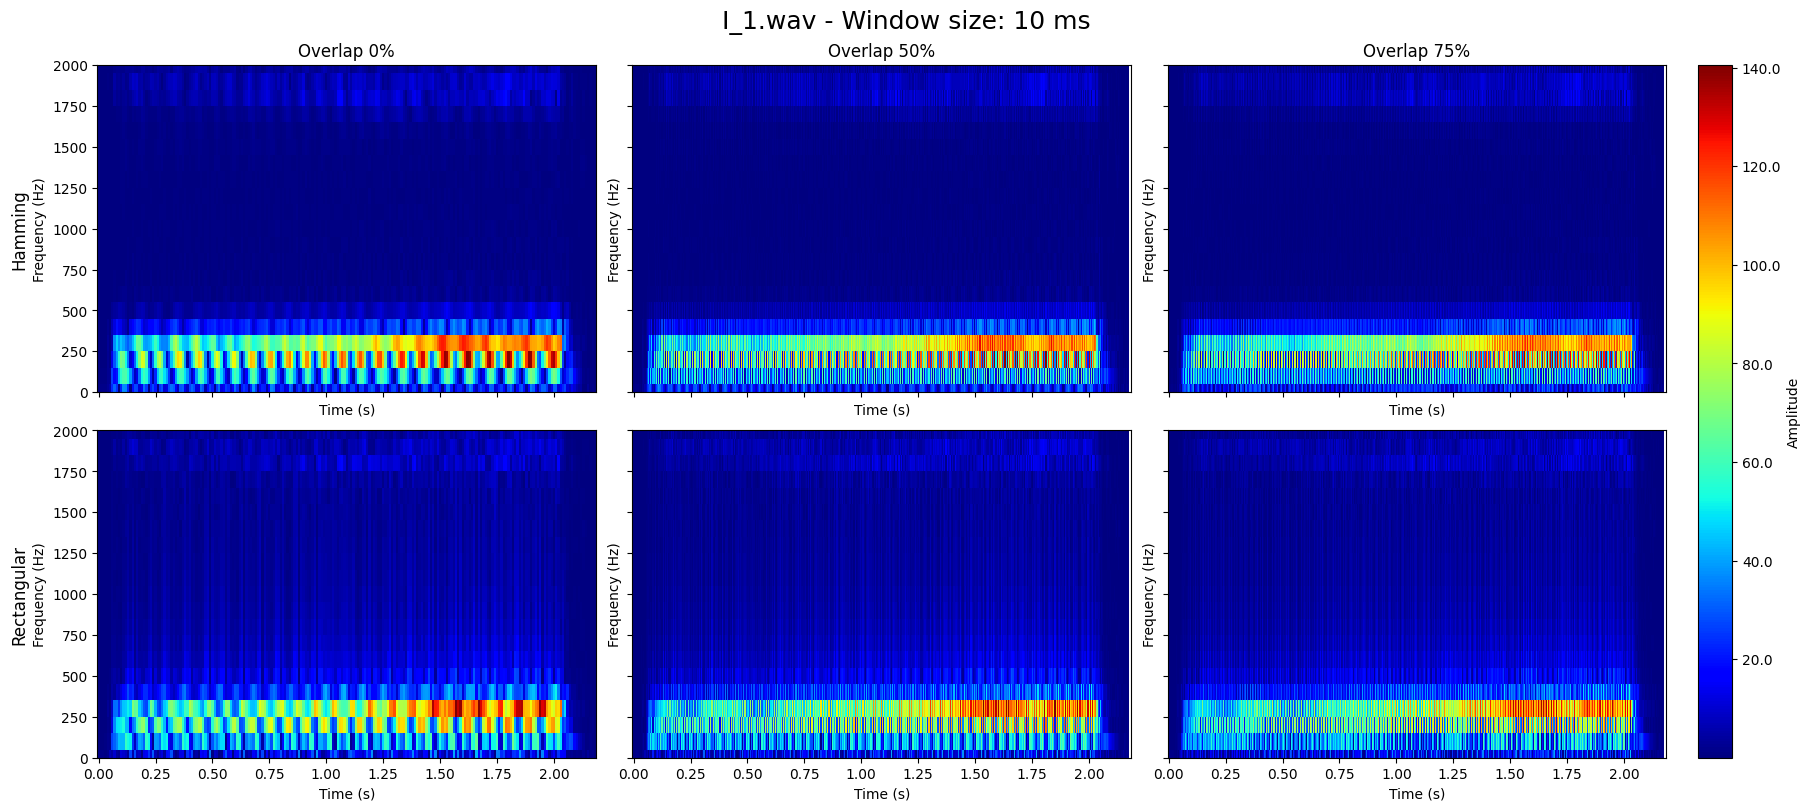

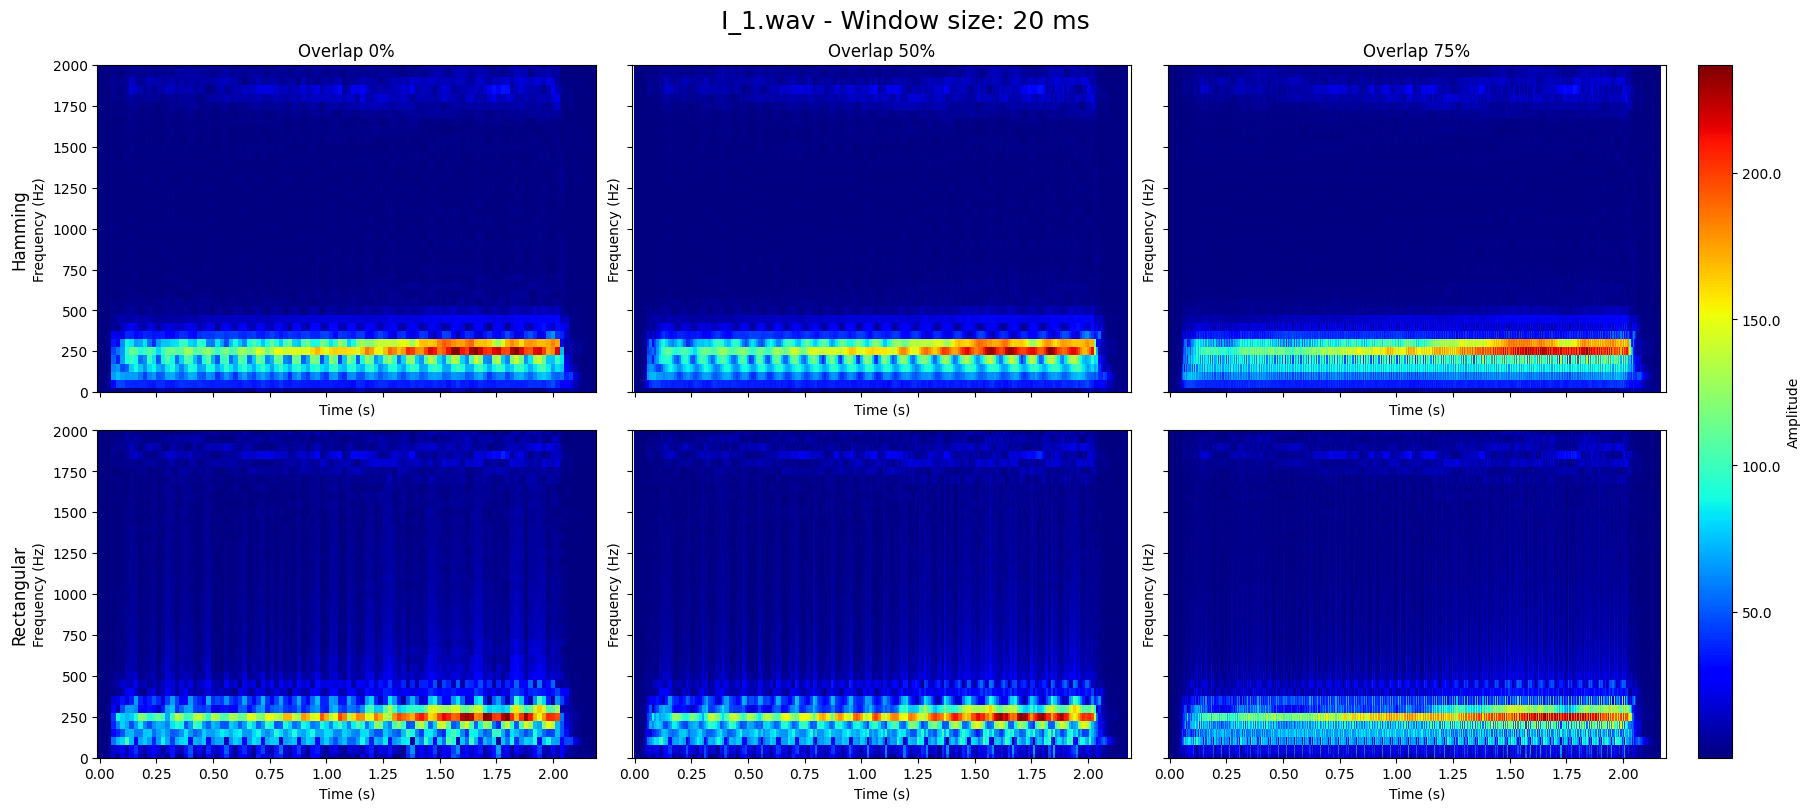

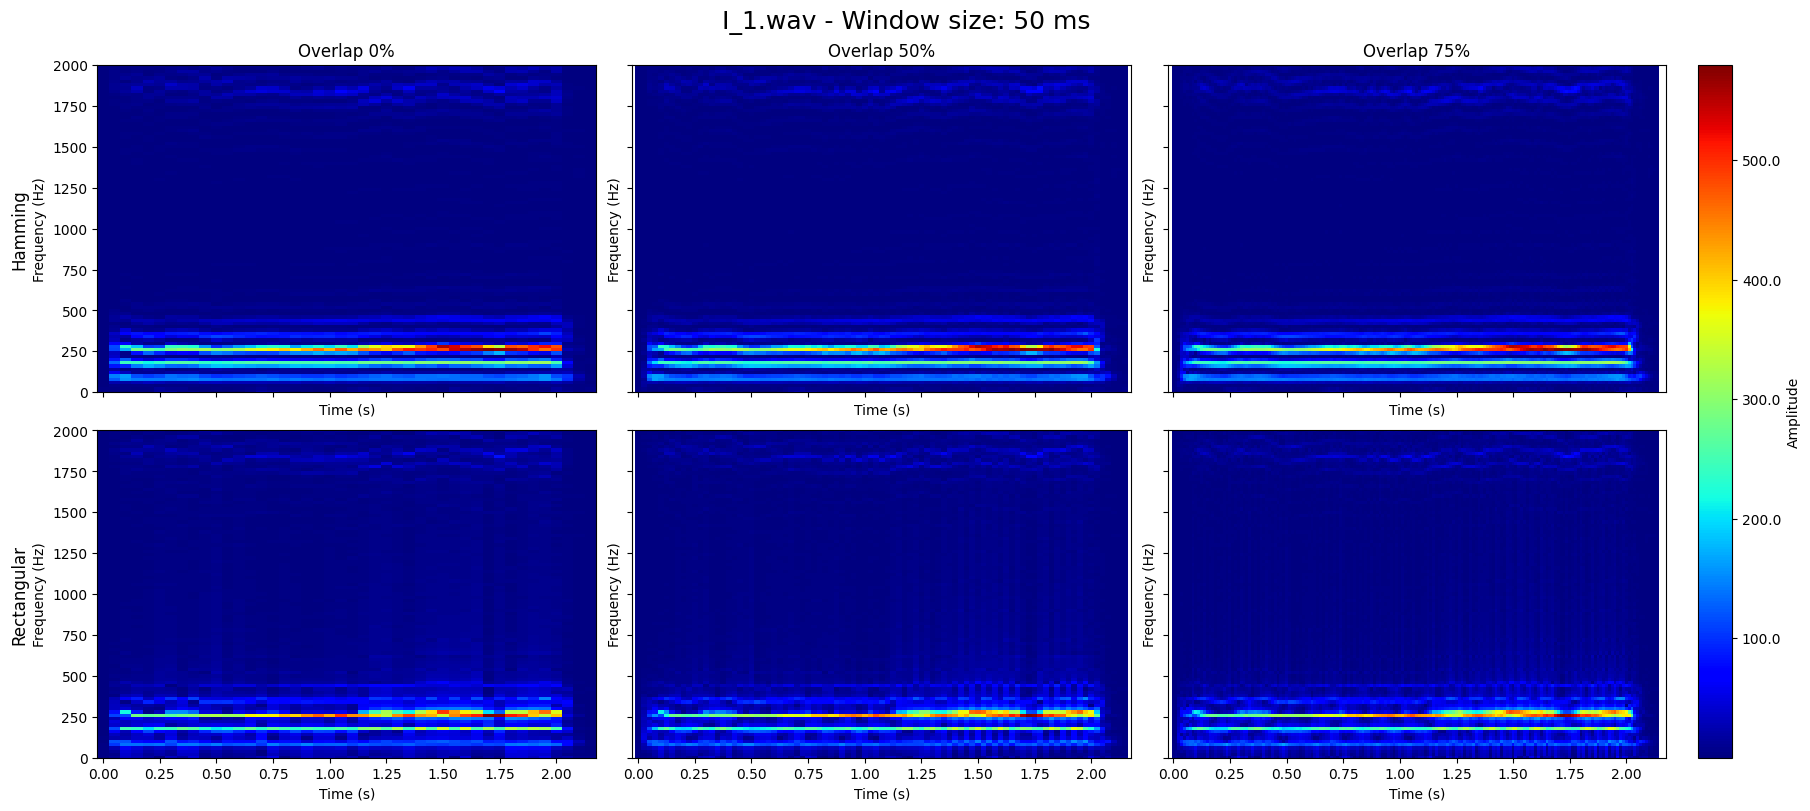

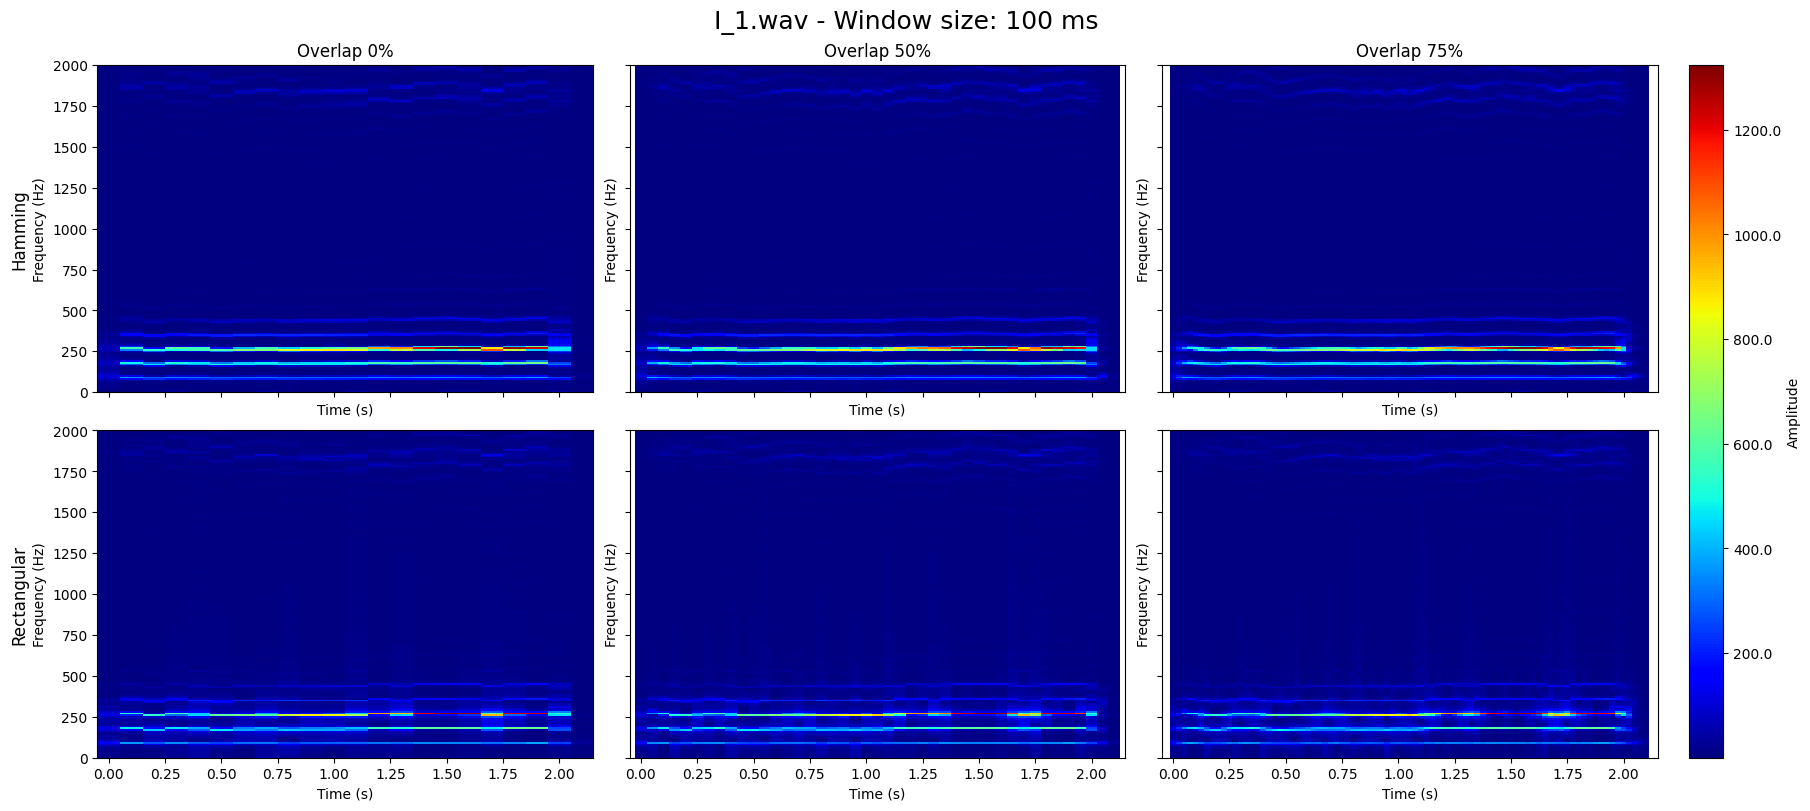



------------------------------ Processing: I_2.wav ------------------------------


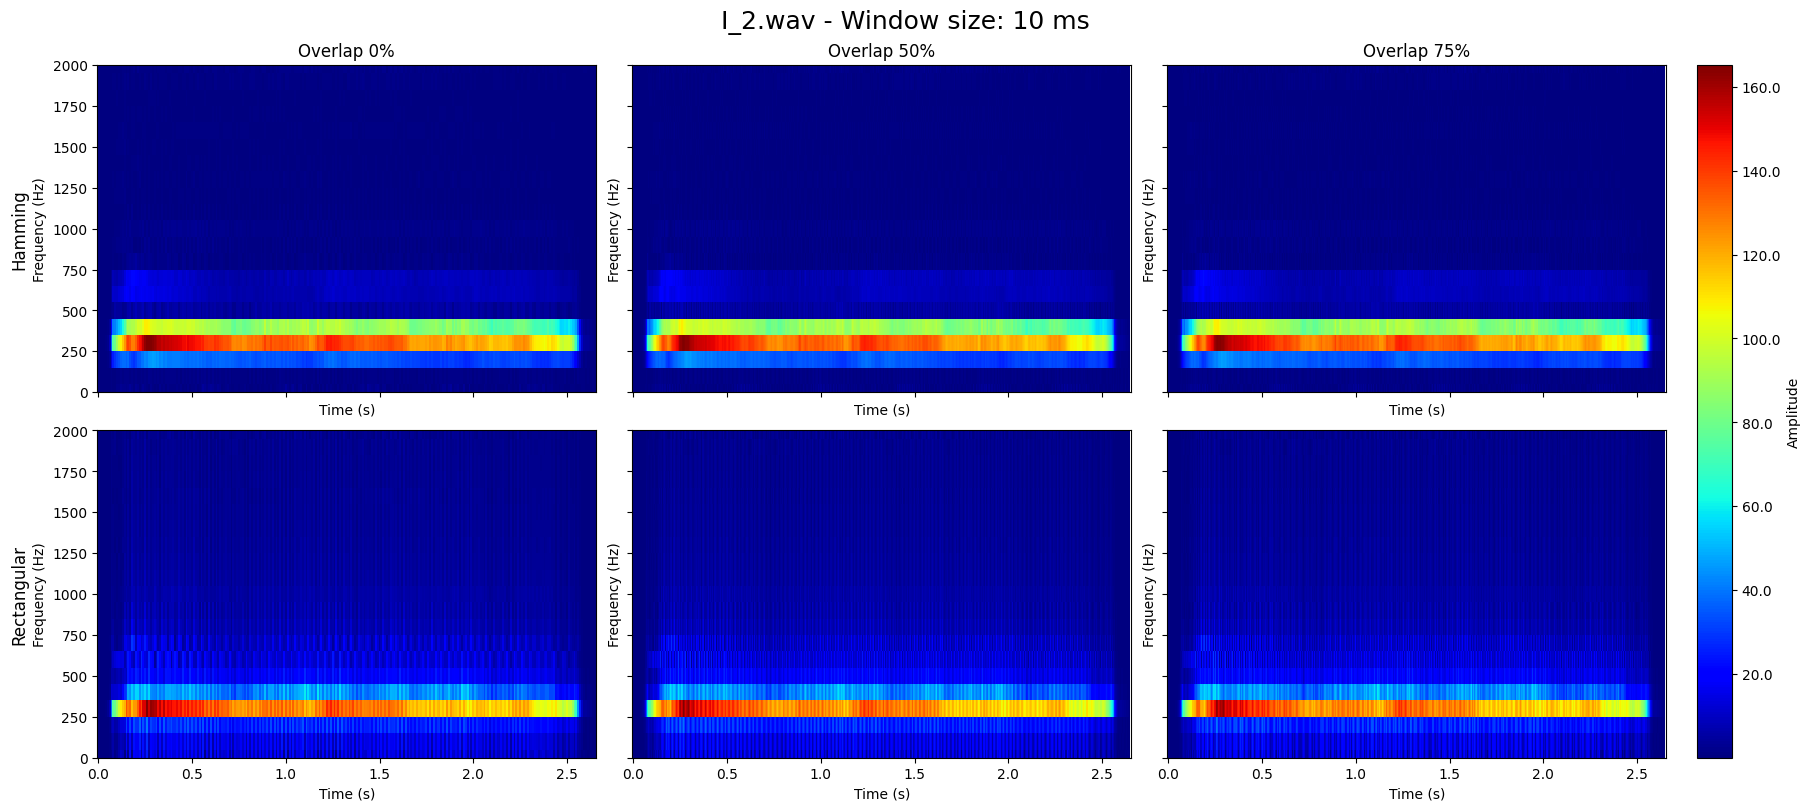

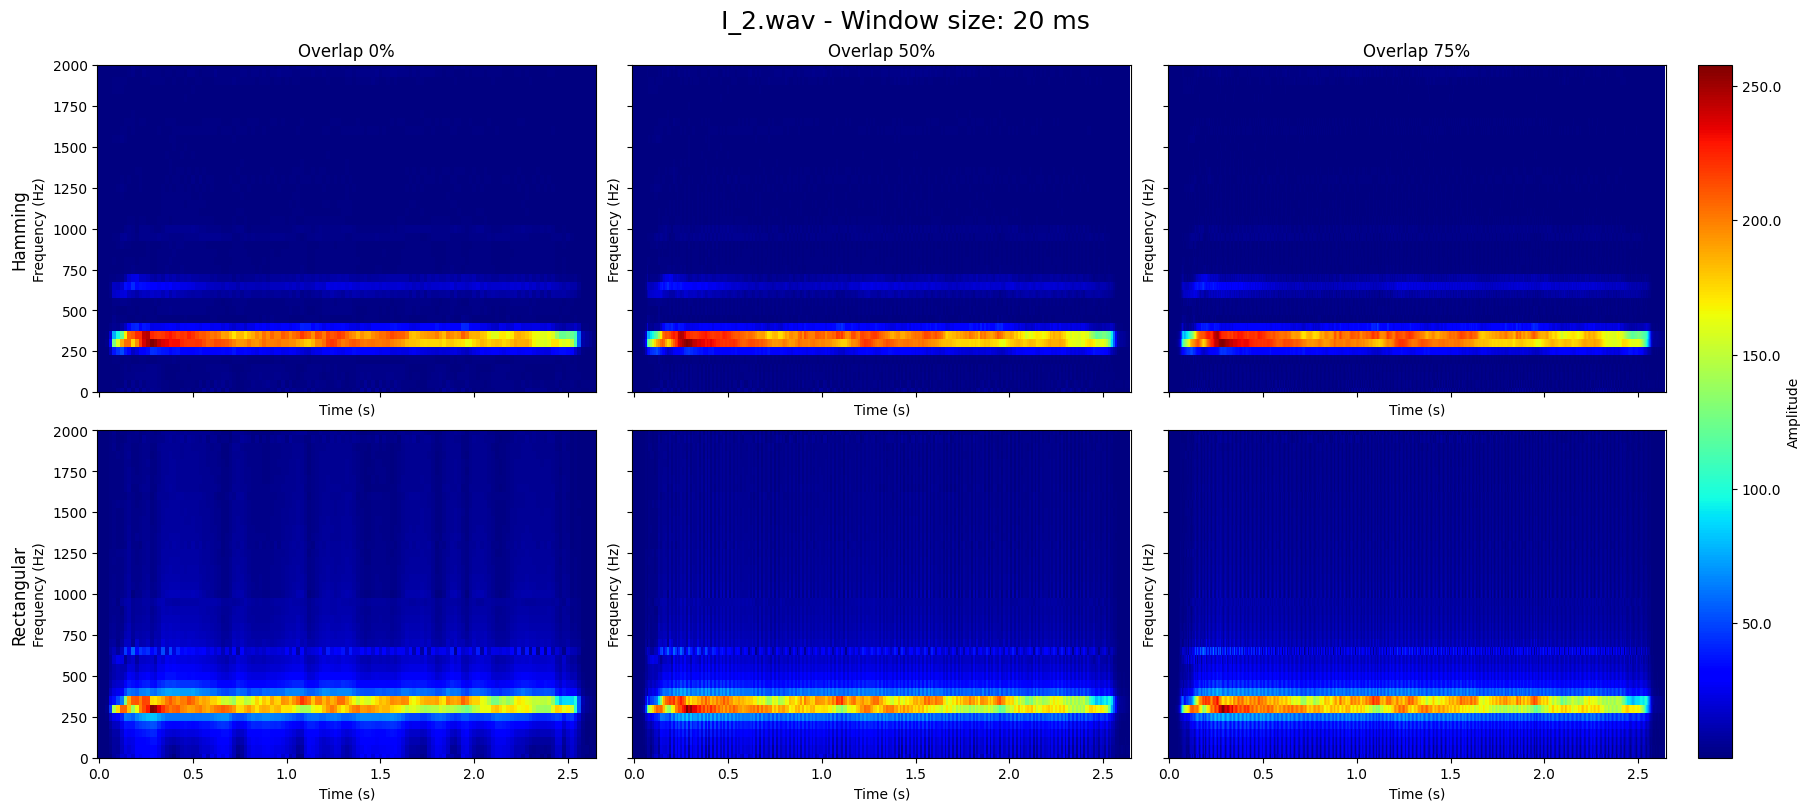

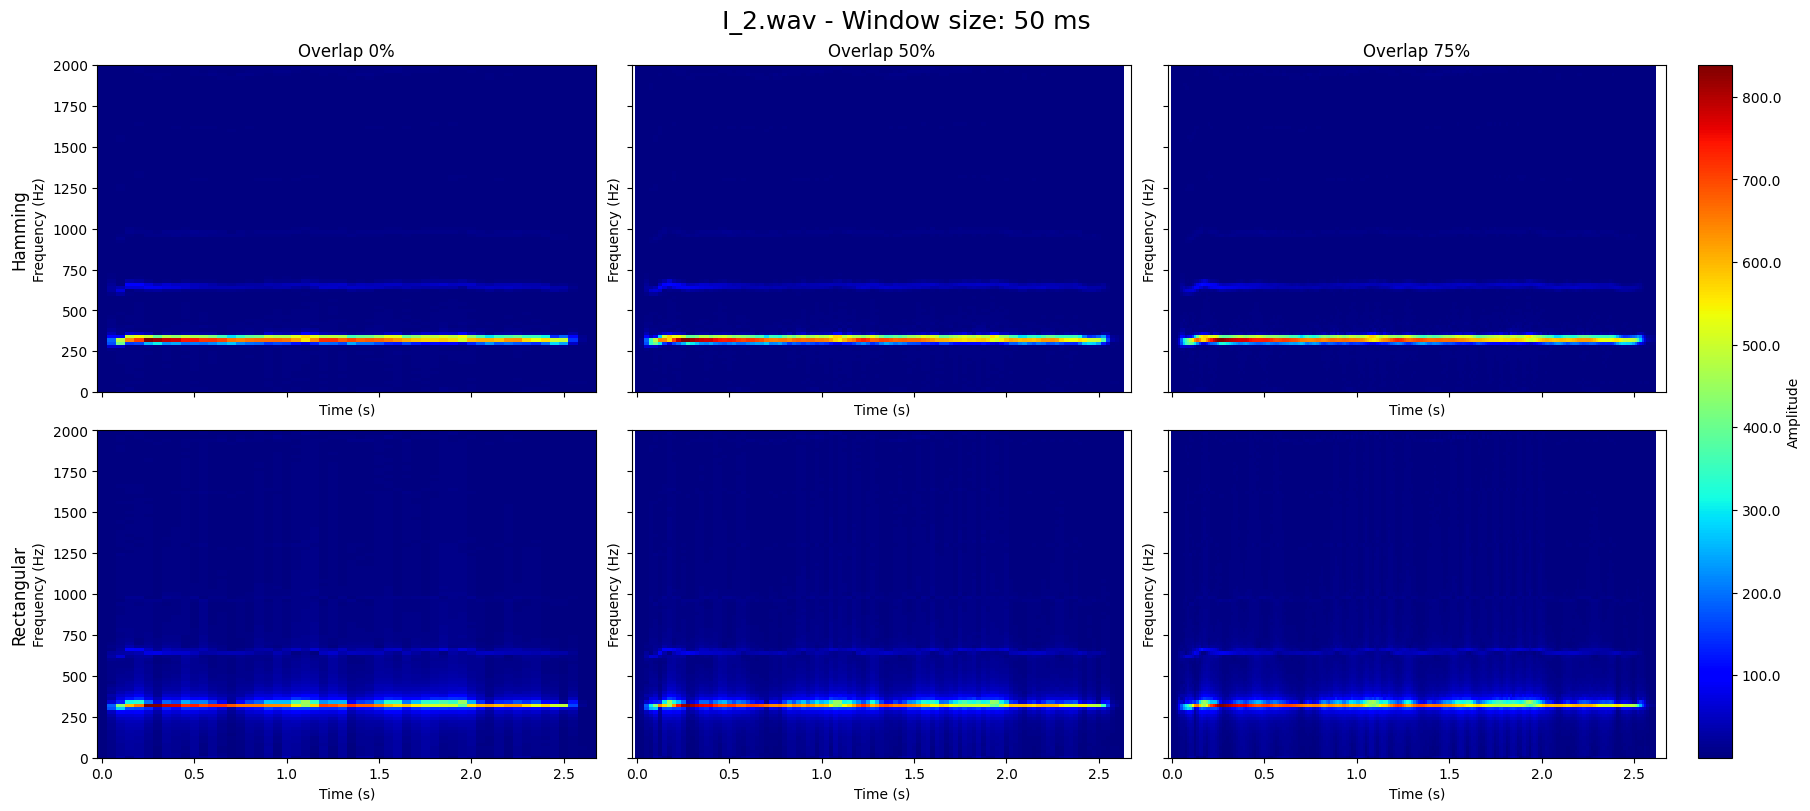

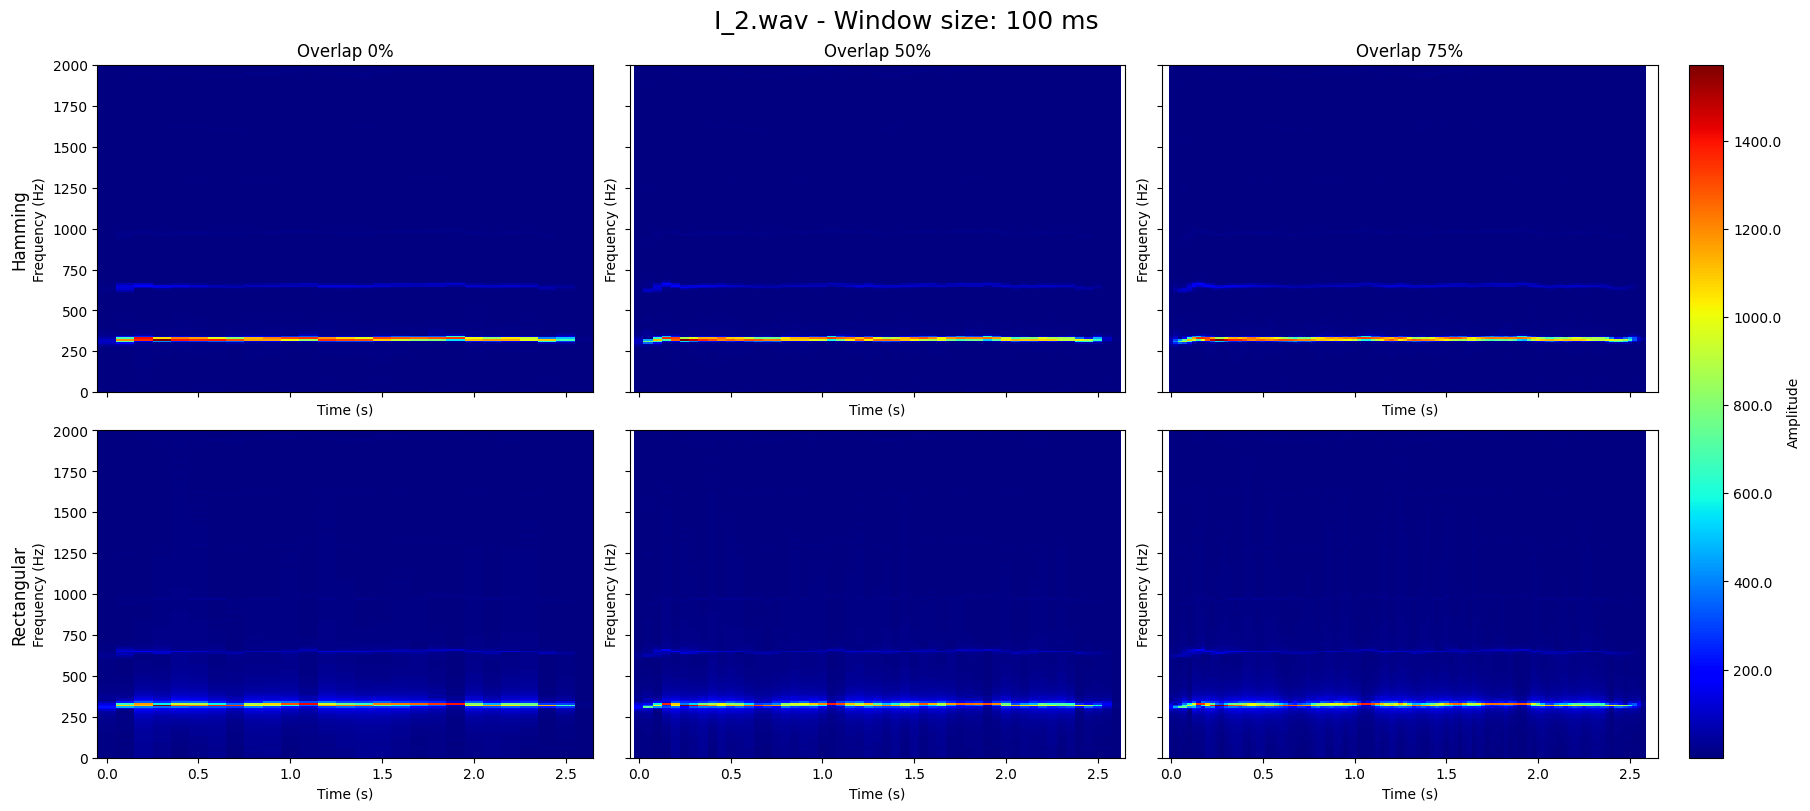



------------------------------ Processing: O_1.wav ------------------------------


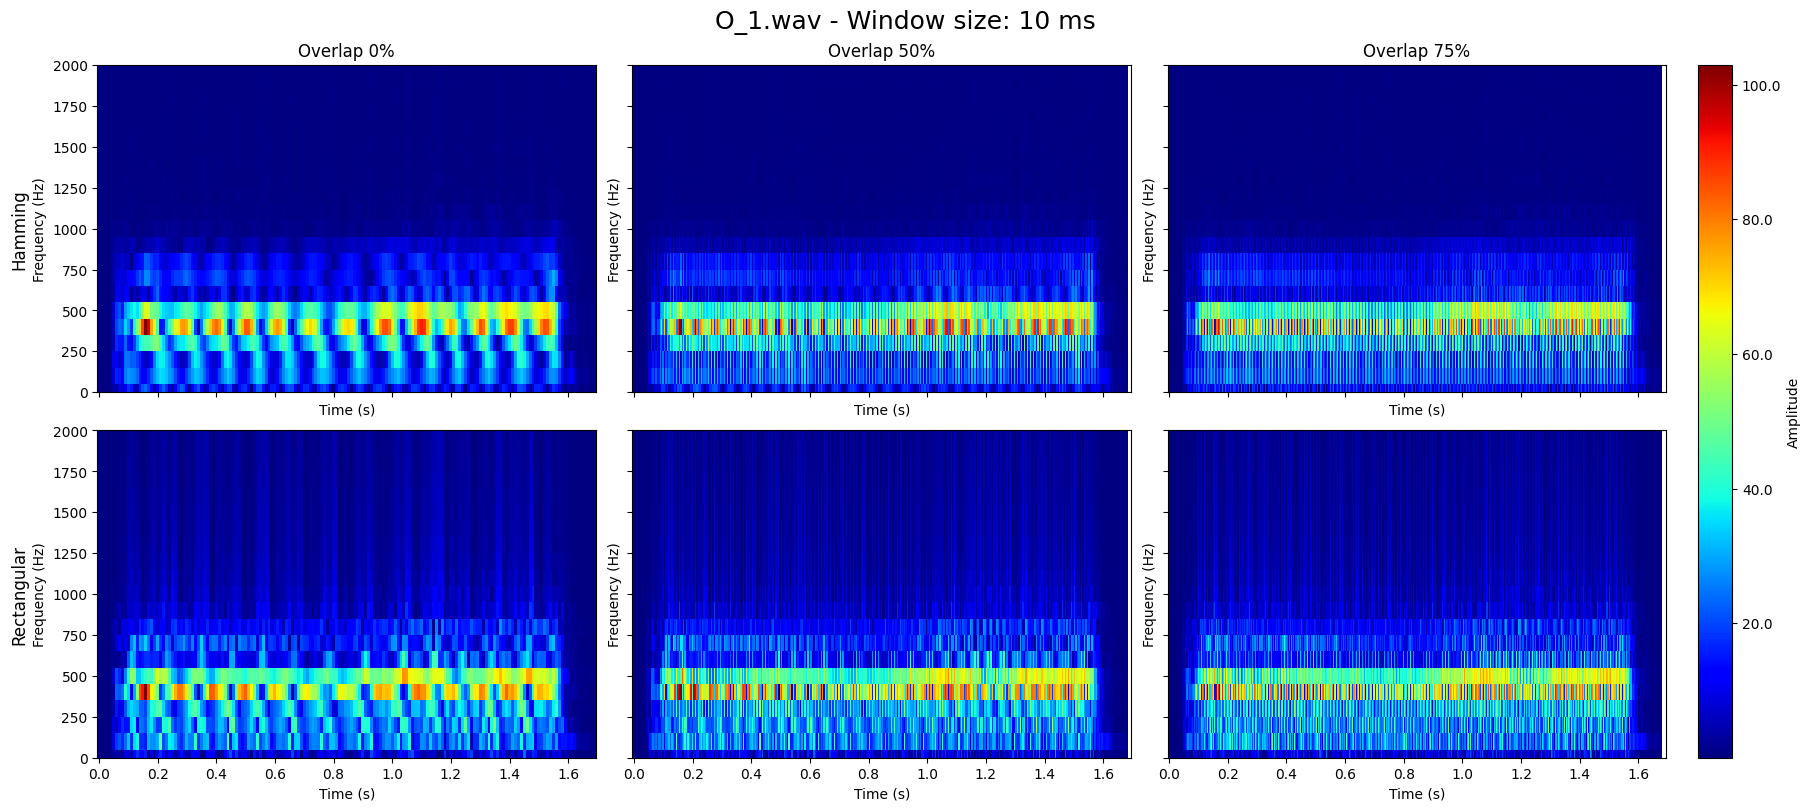

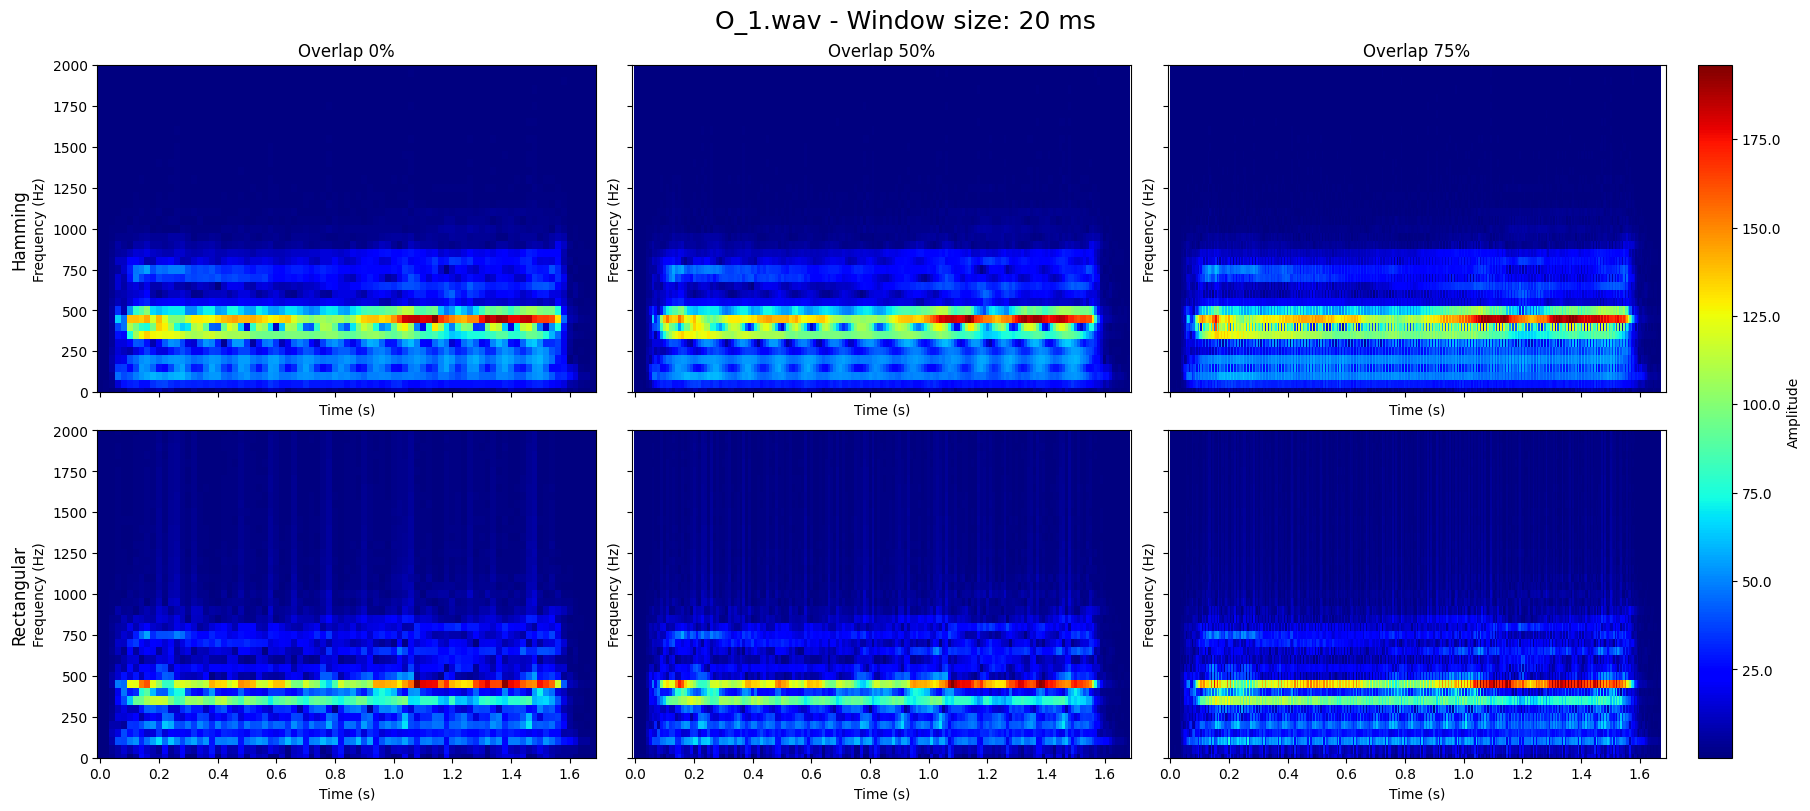

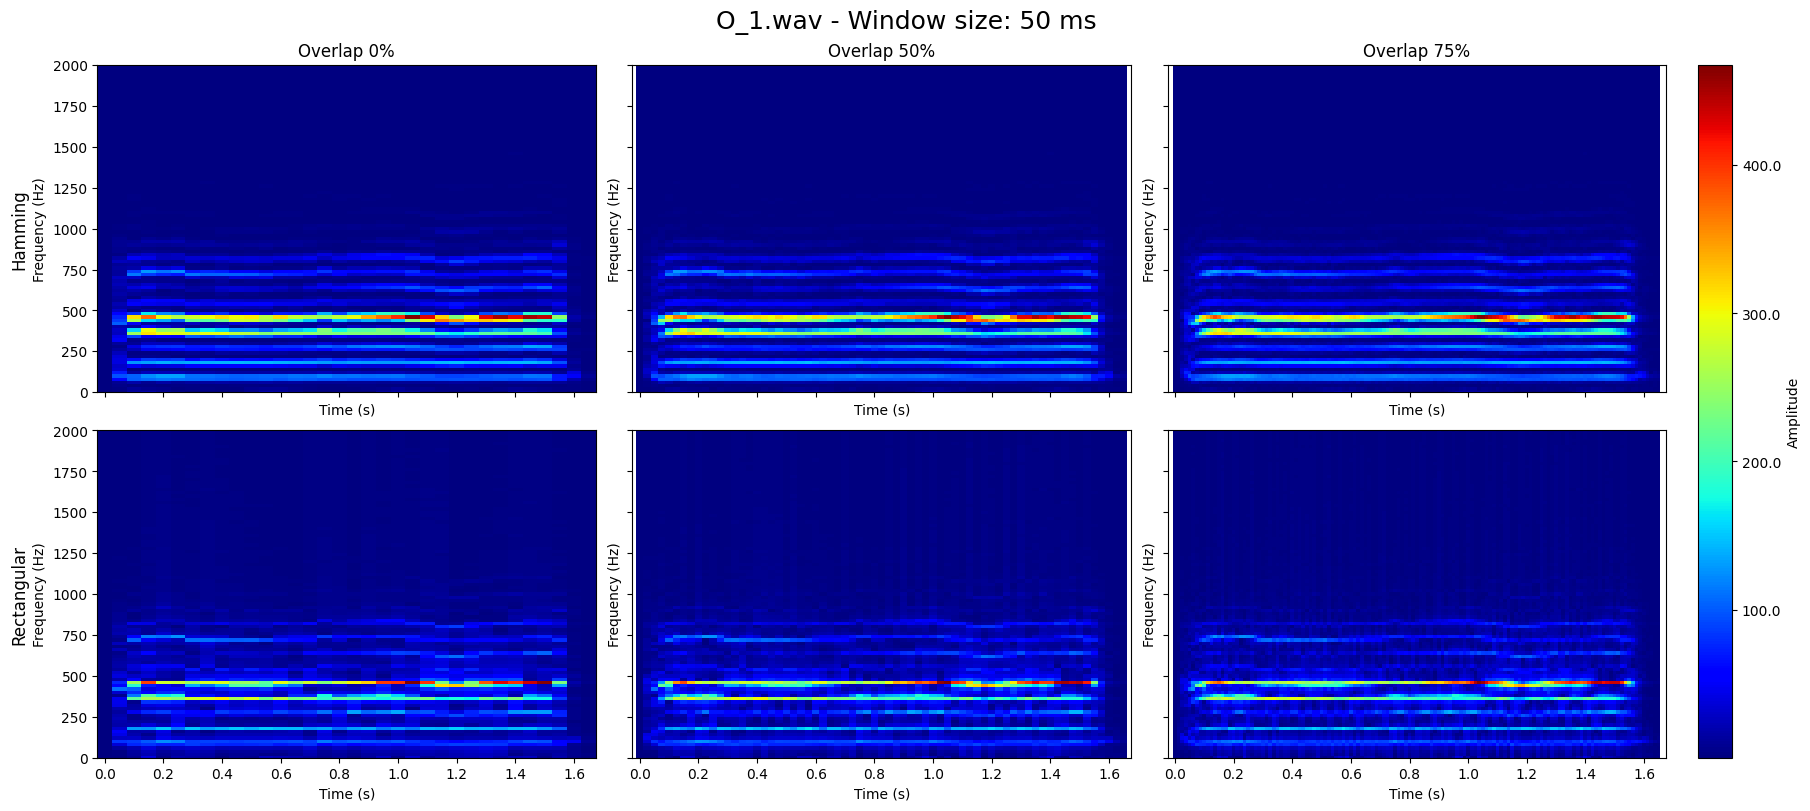

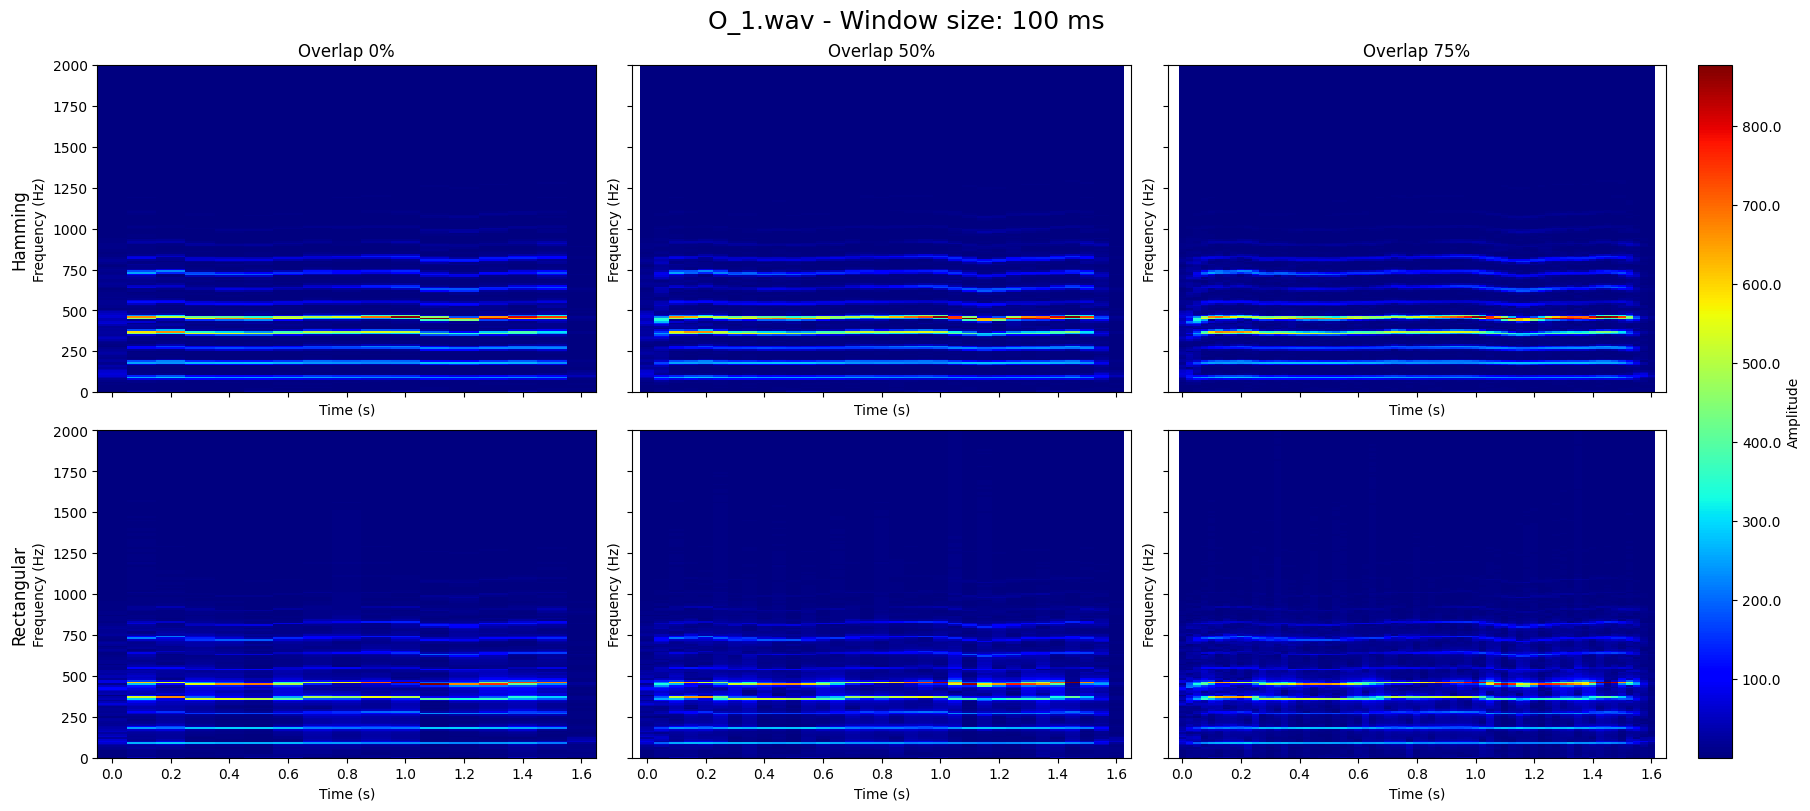



------------------------------ Processing: O_2.wav ------------------------------


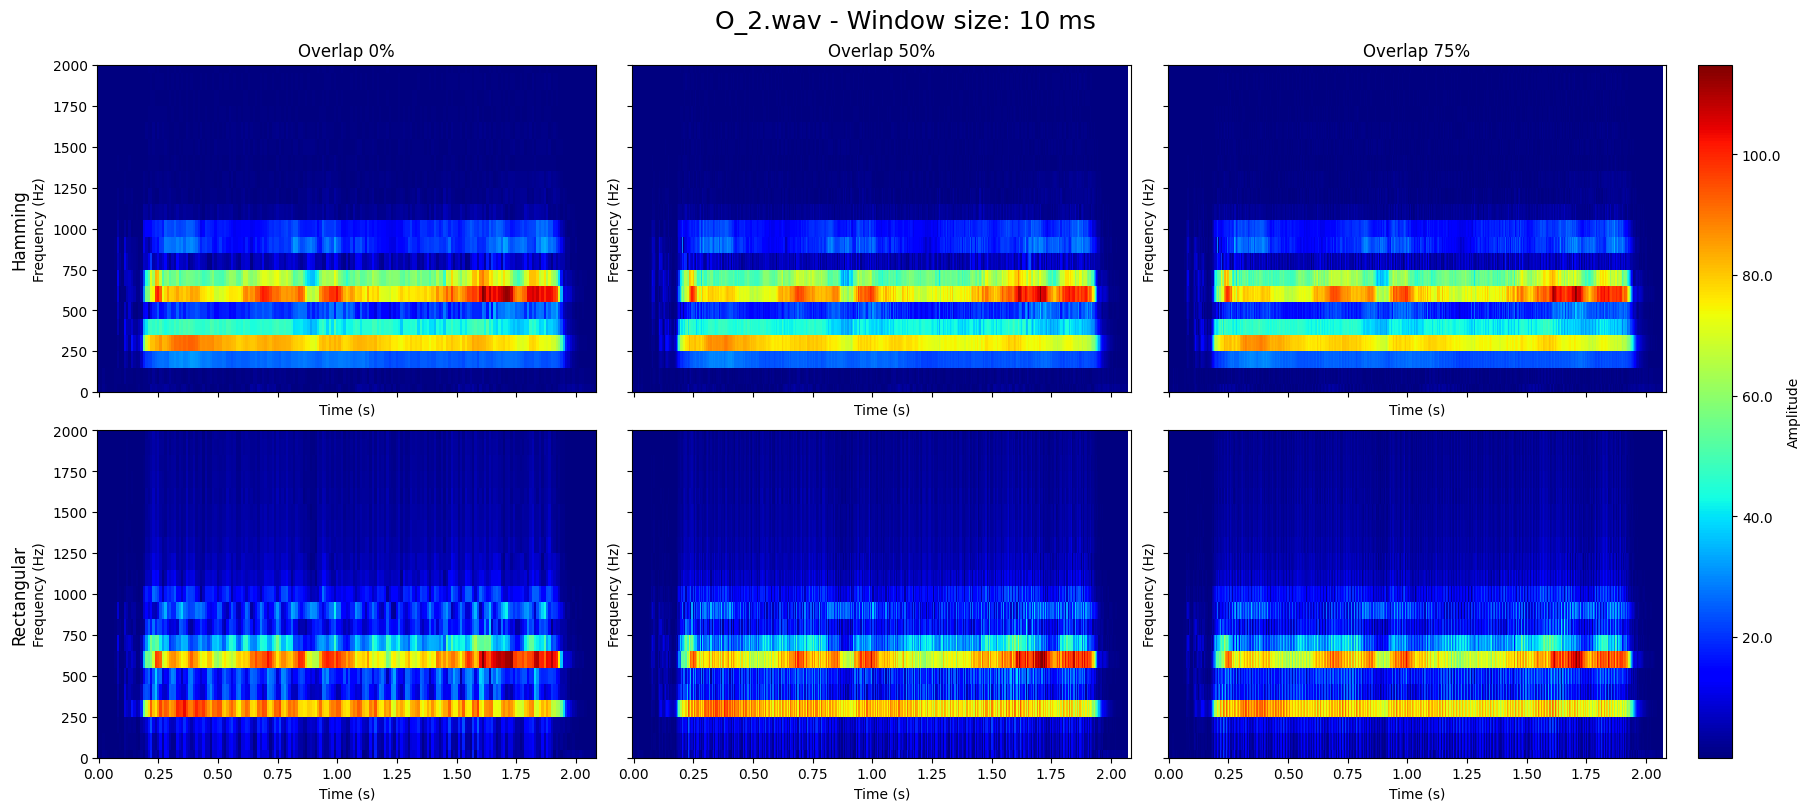

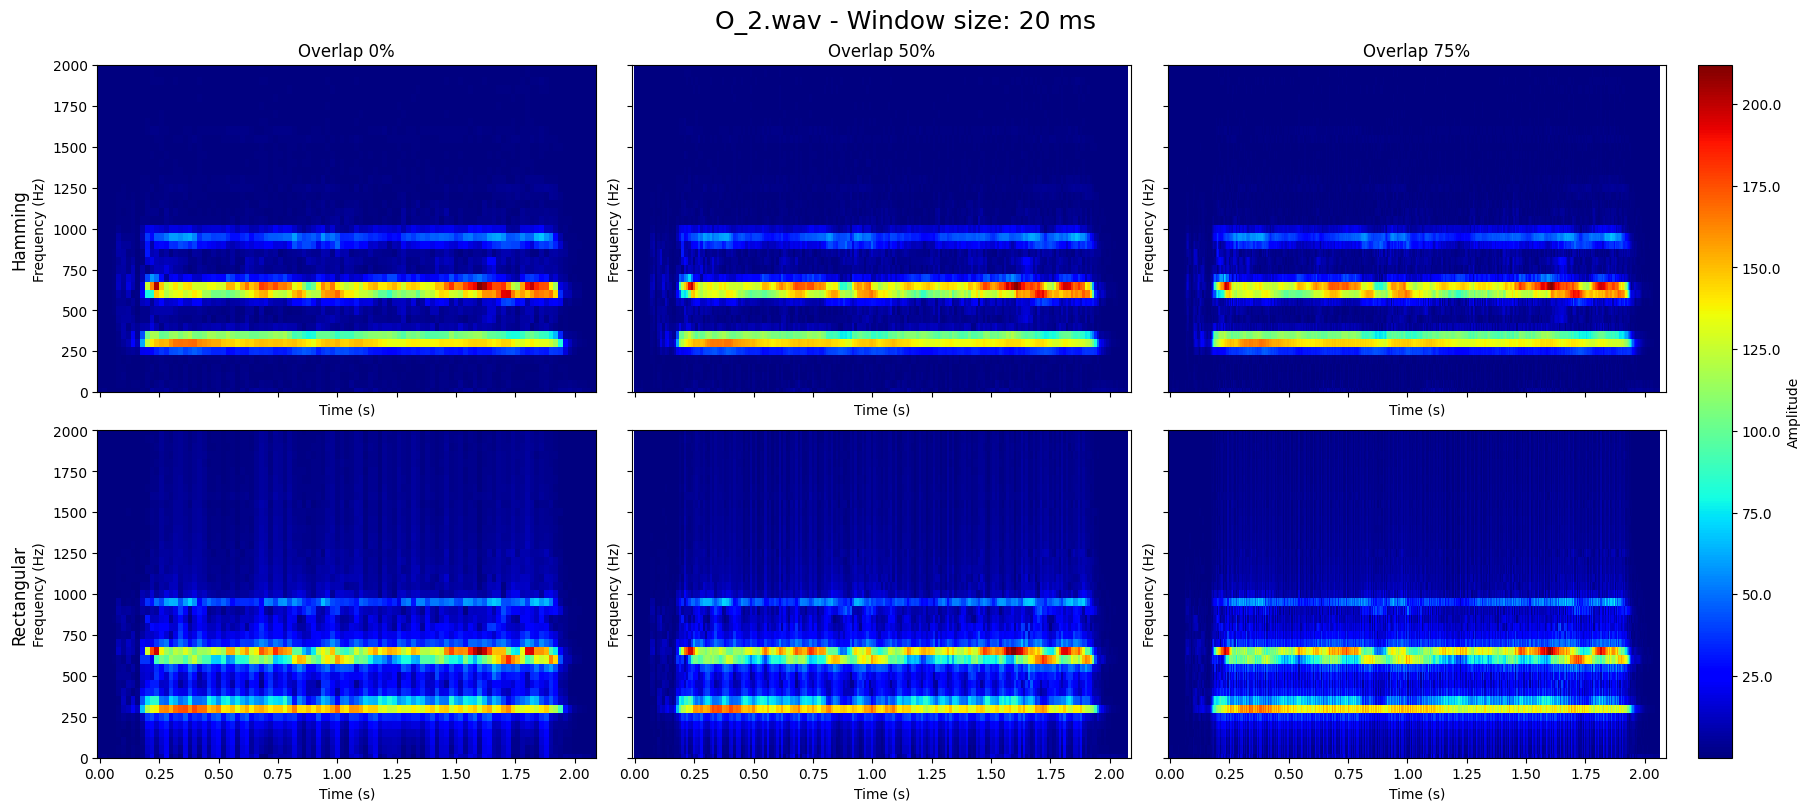

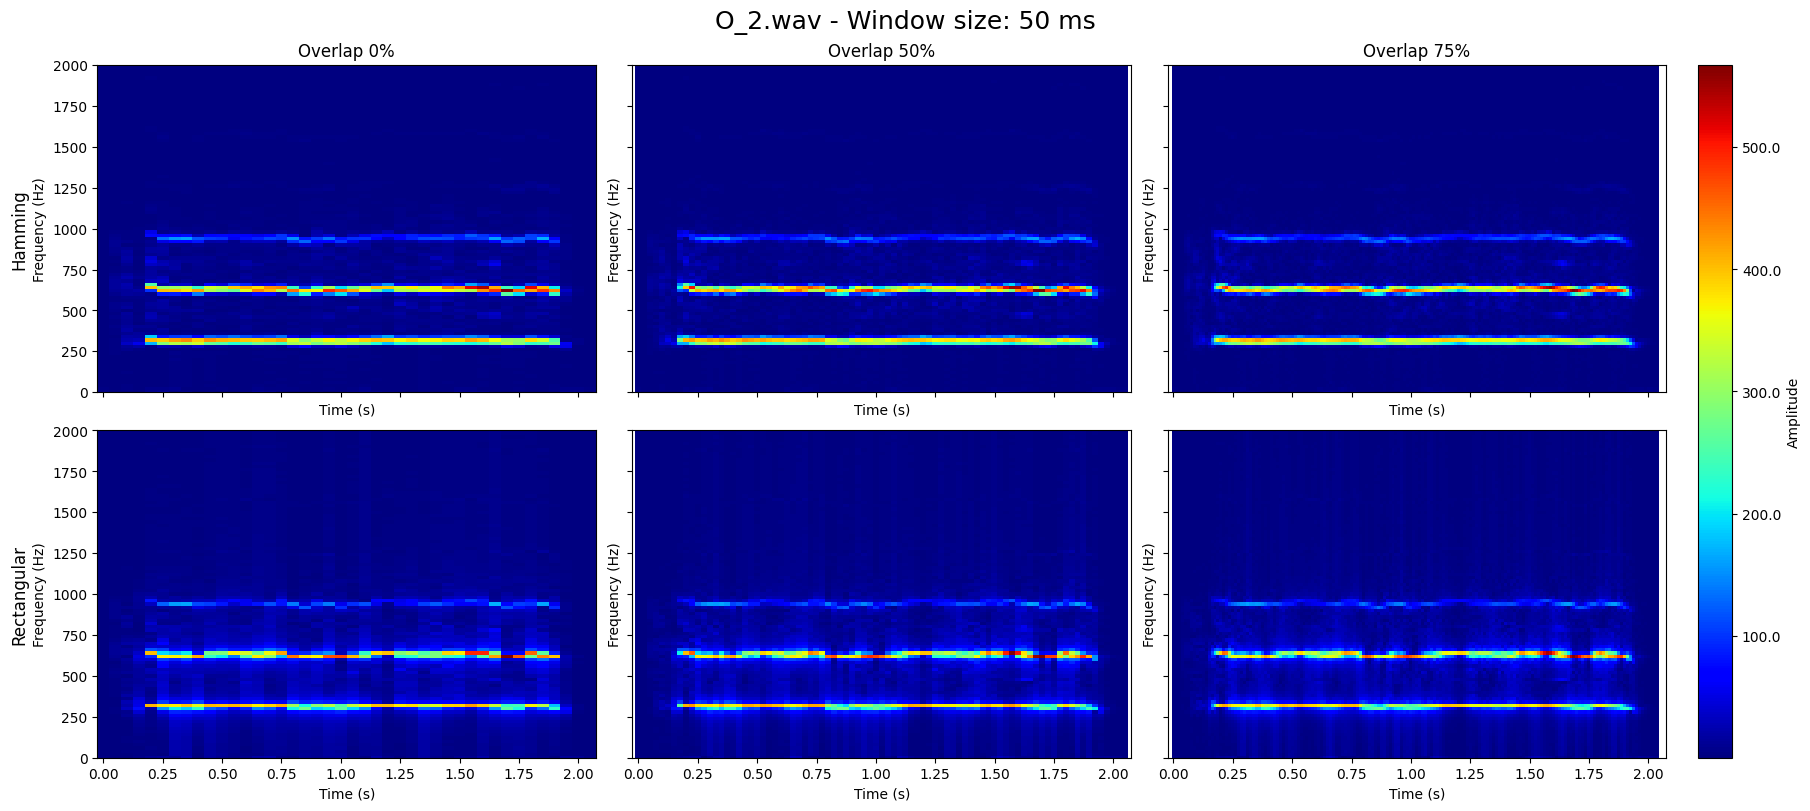

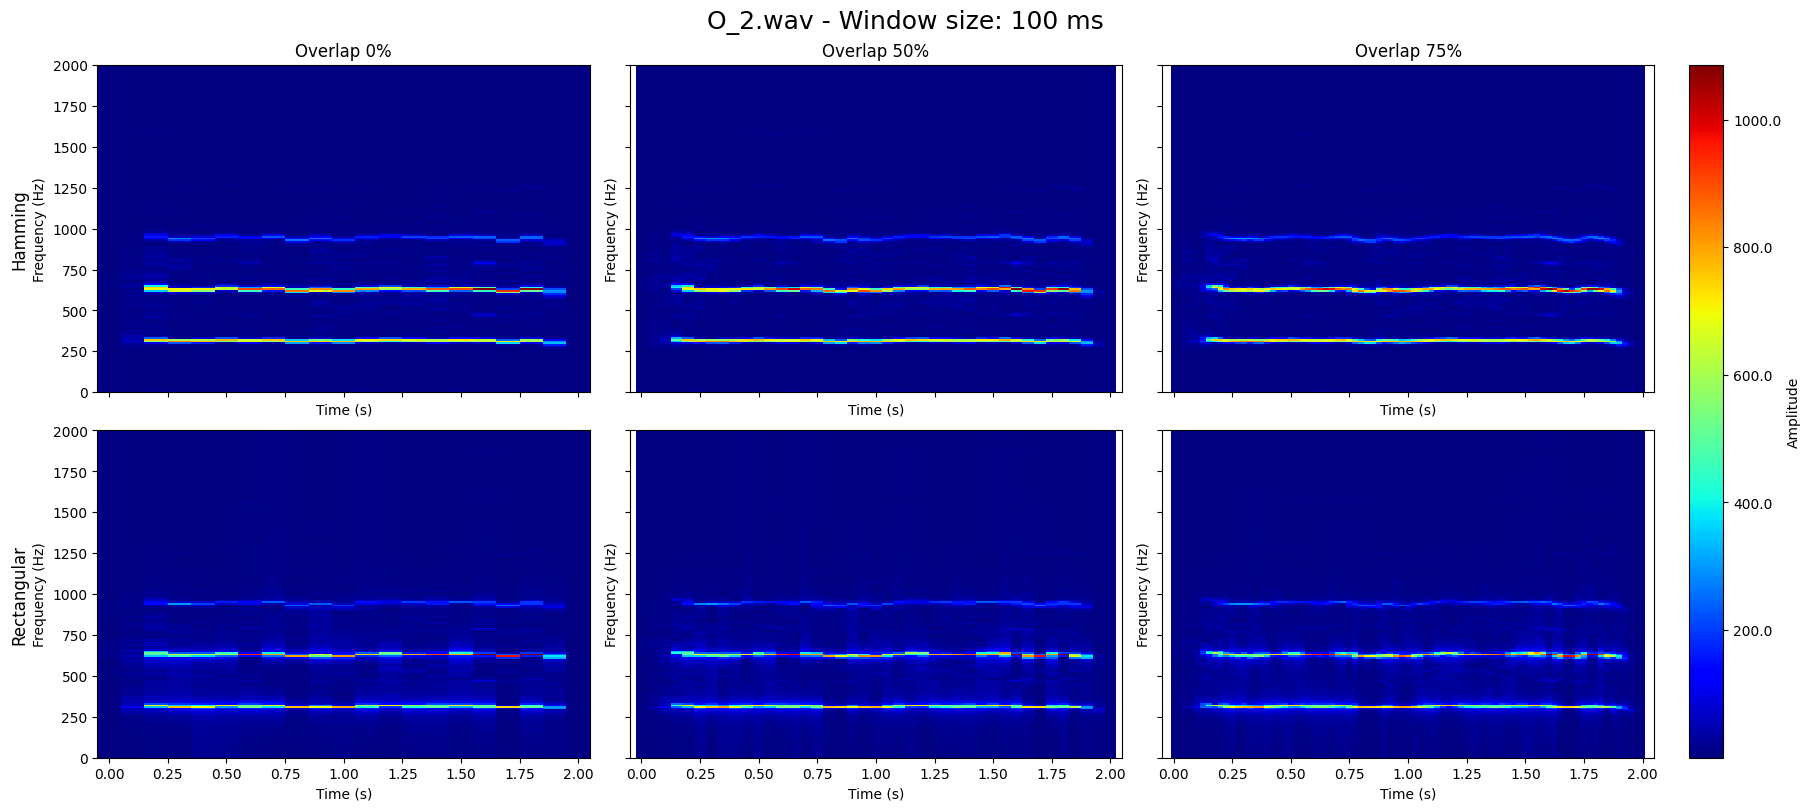



------------------------------ Processing: zvizganje1.wav ------------------------------


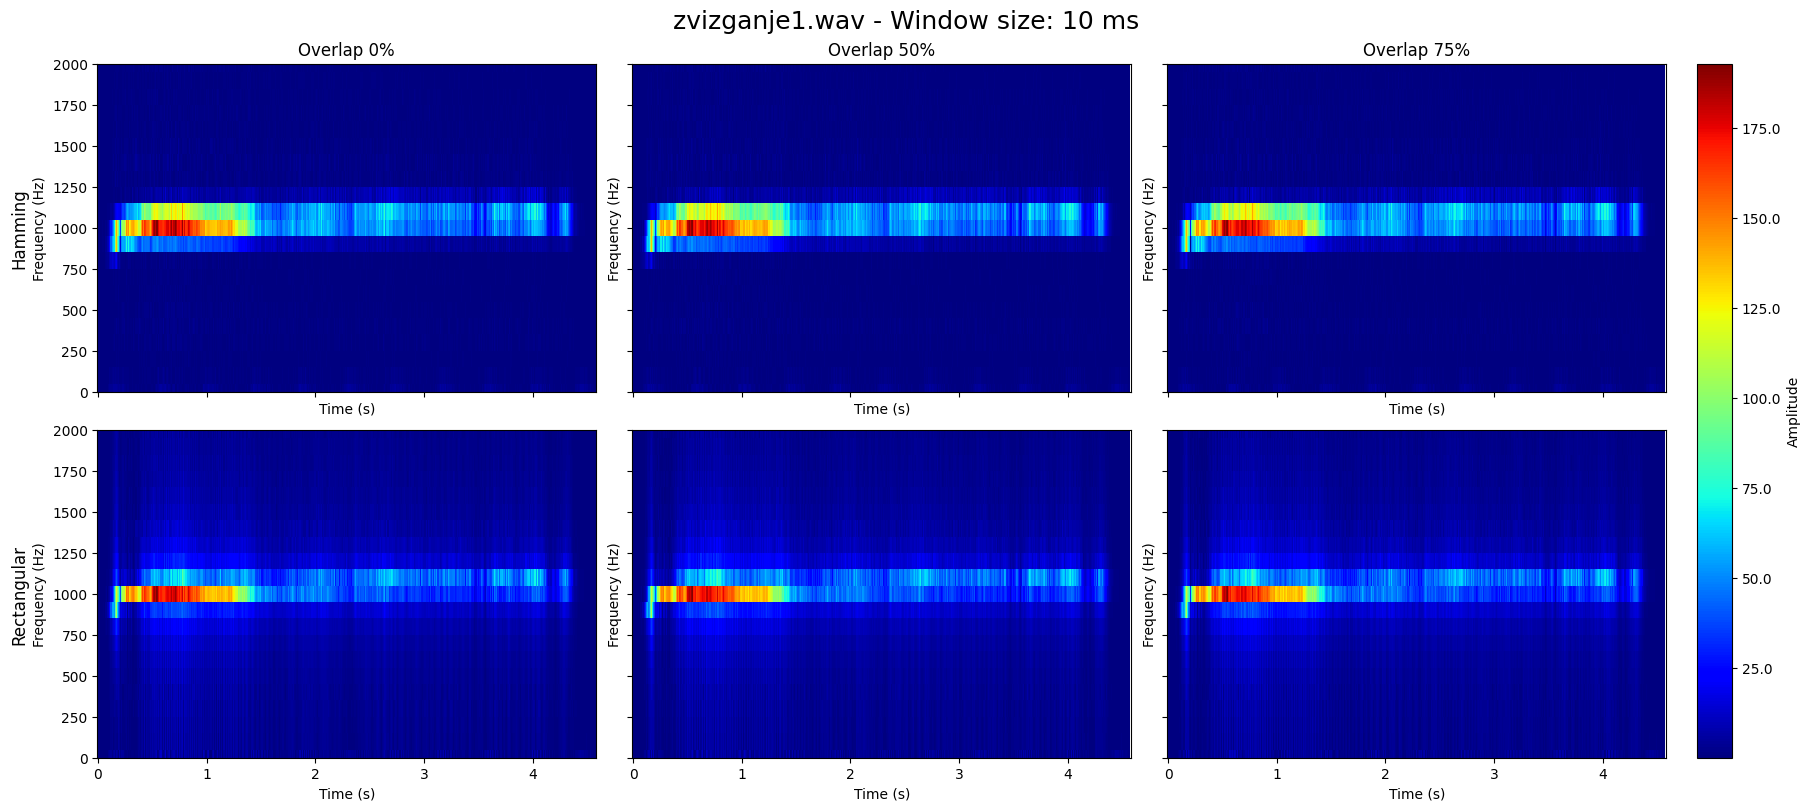

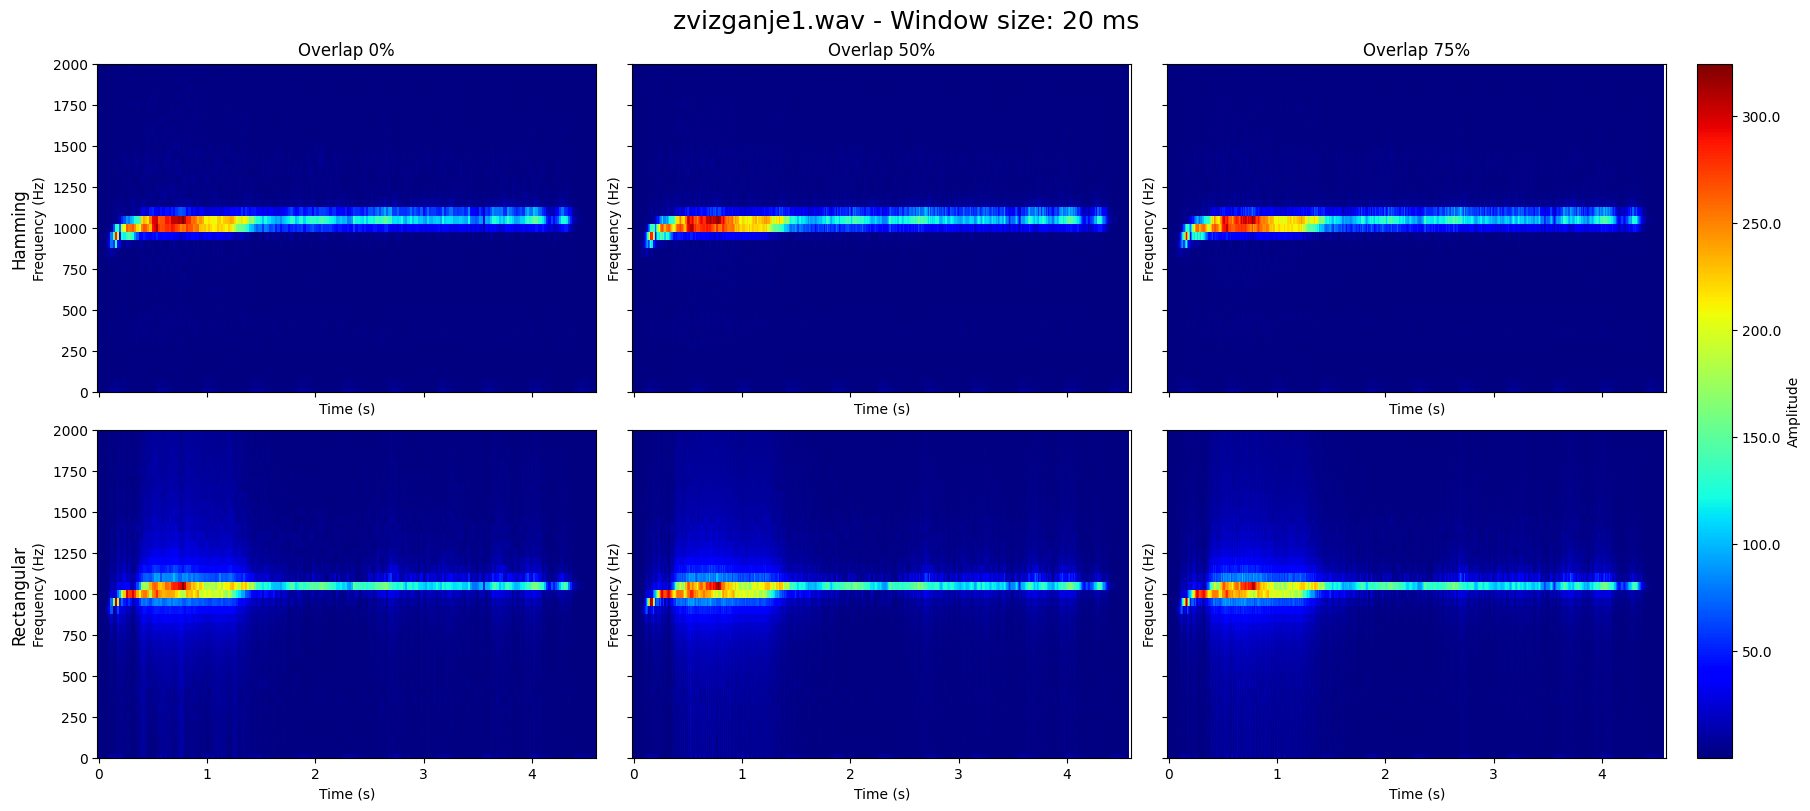

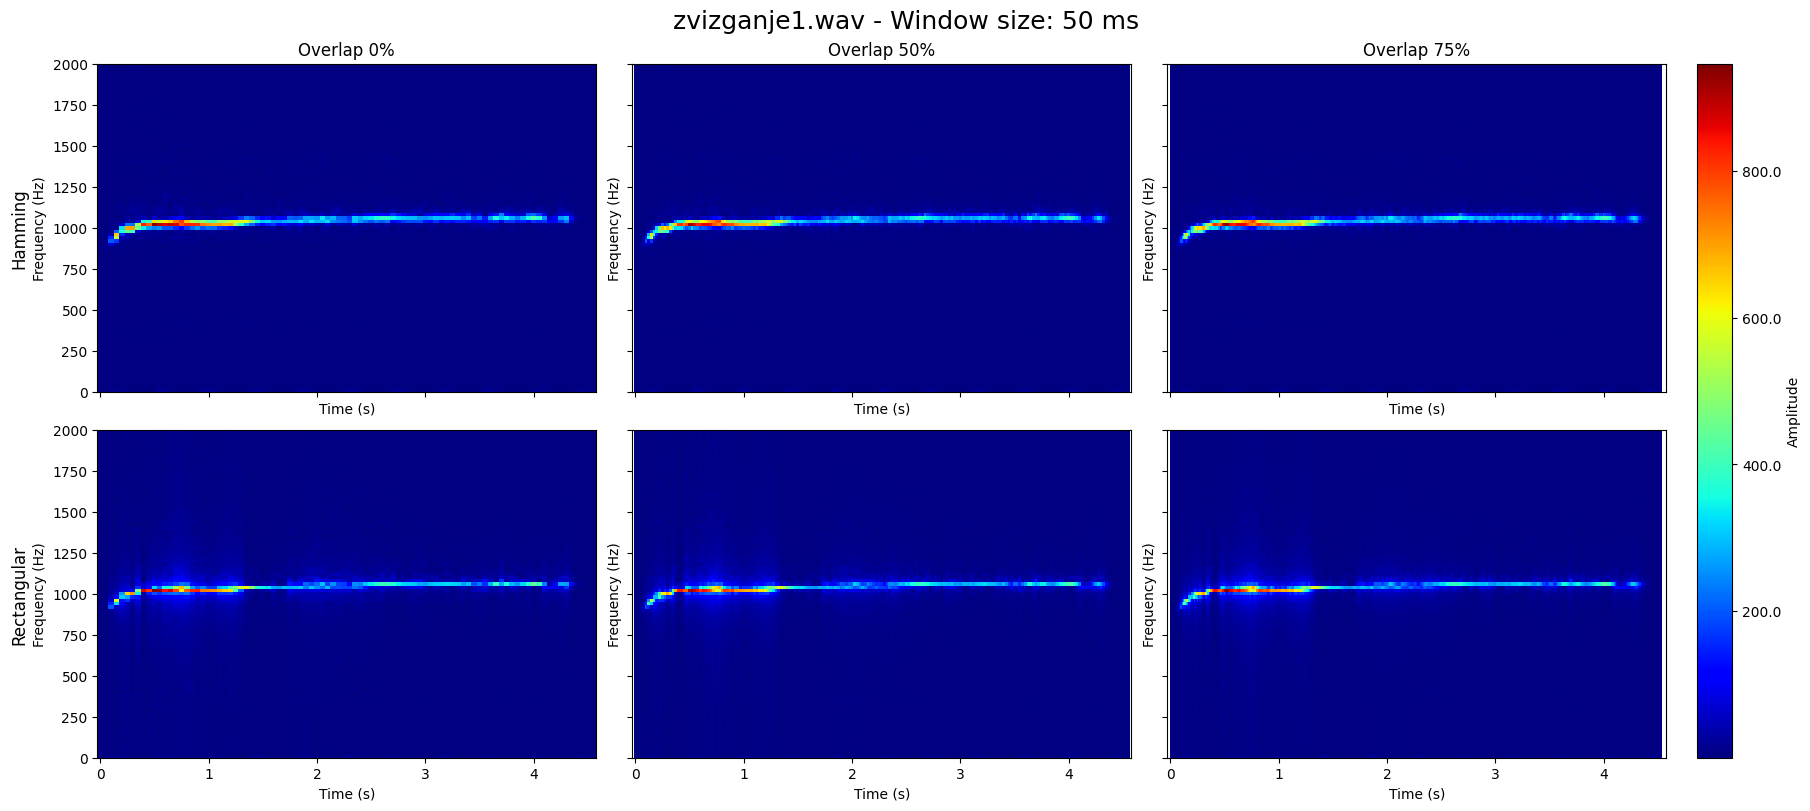

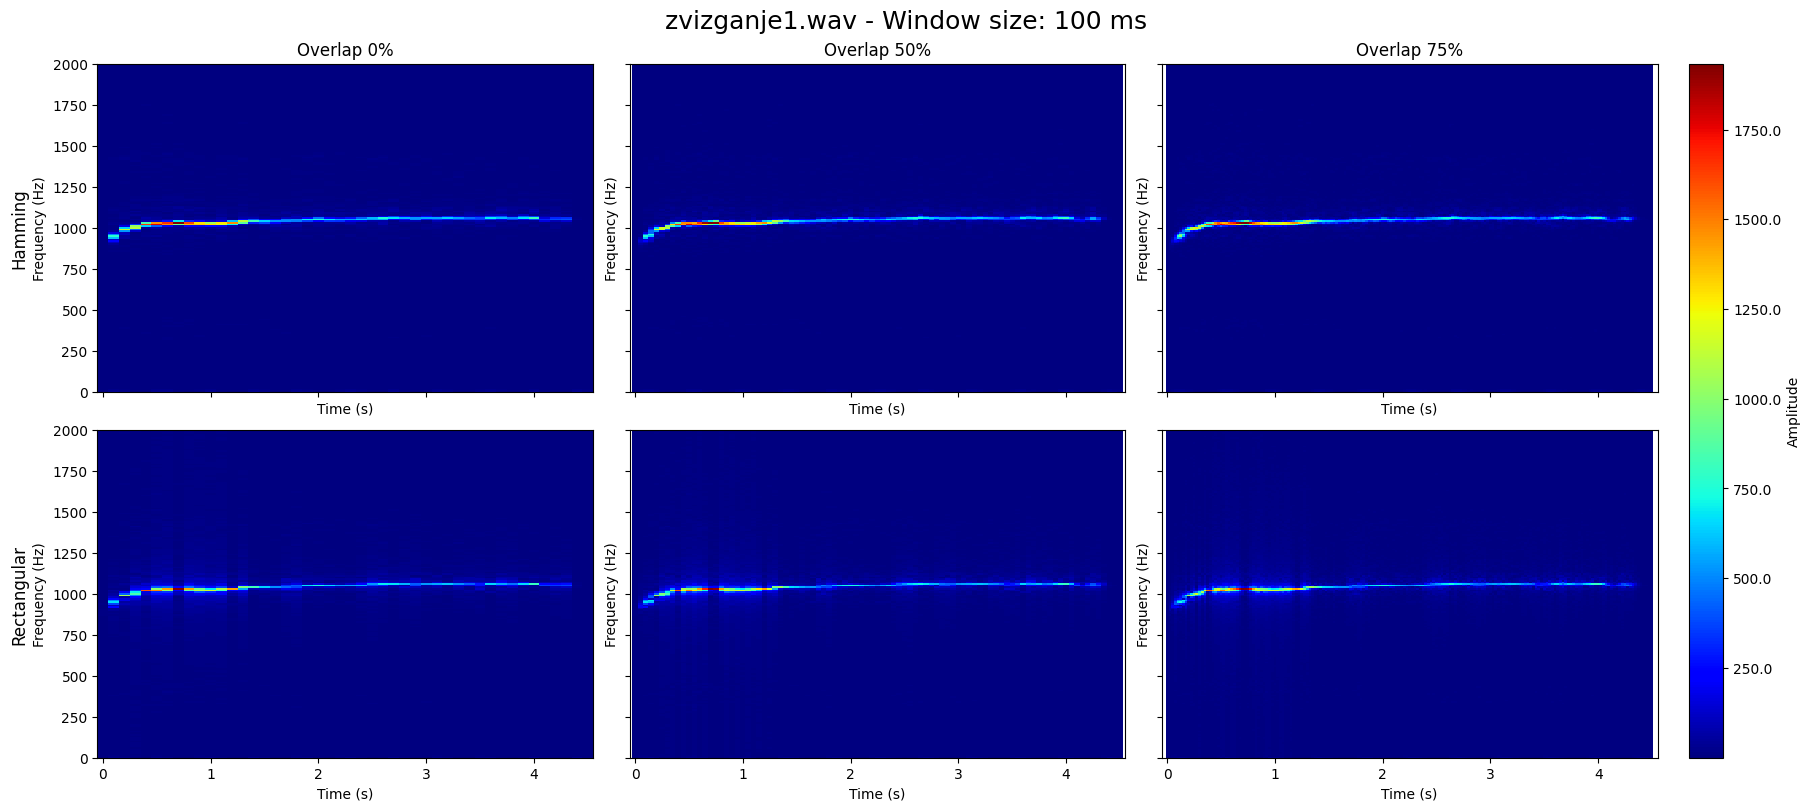



------------------------------ Processing: zvizganje2.wav ------------------------------


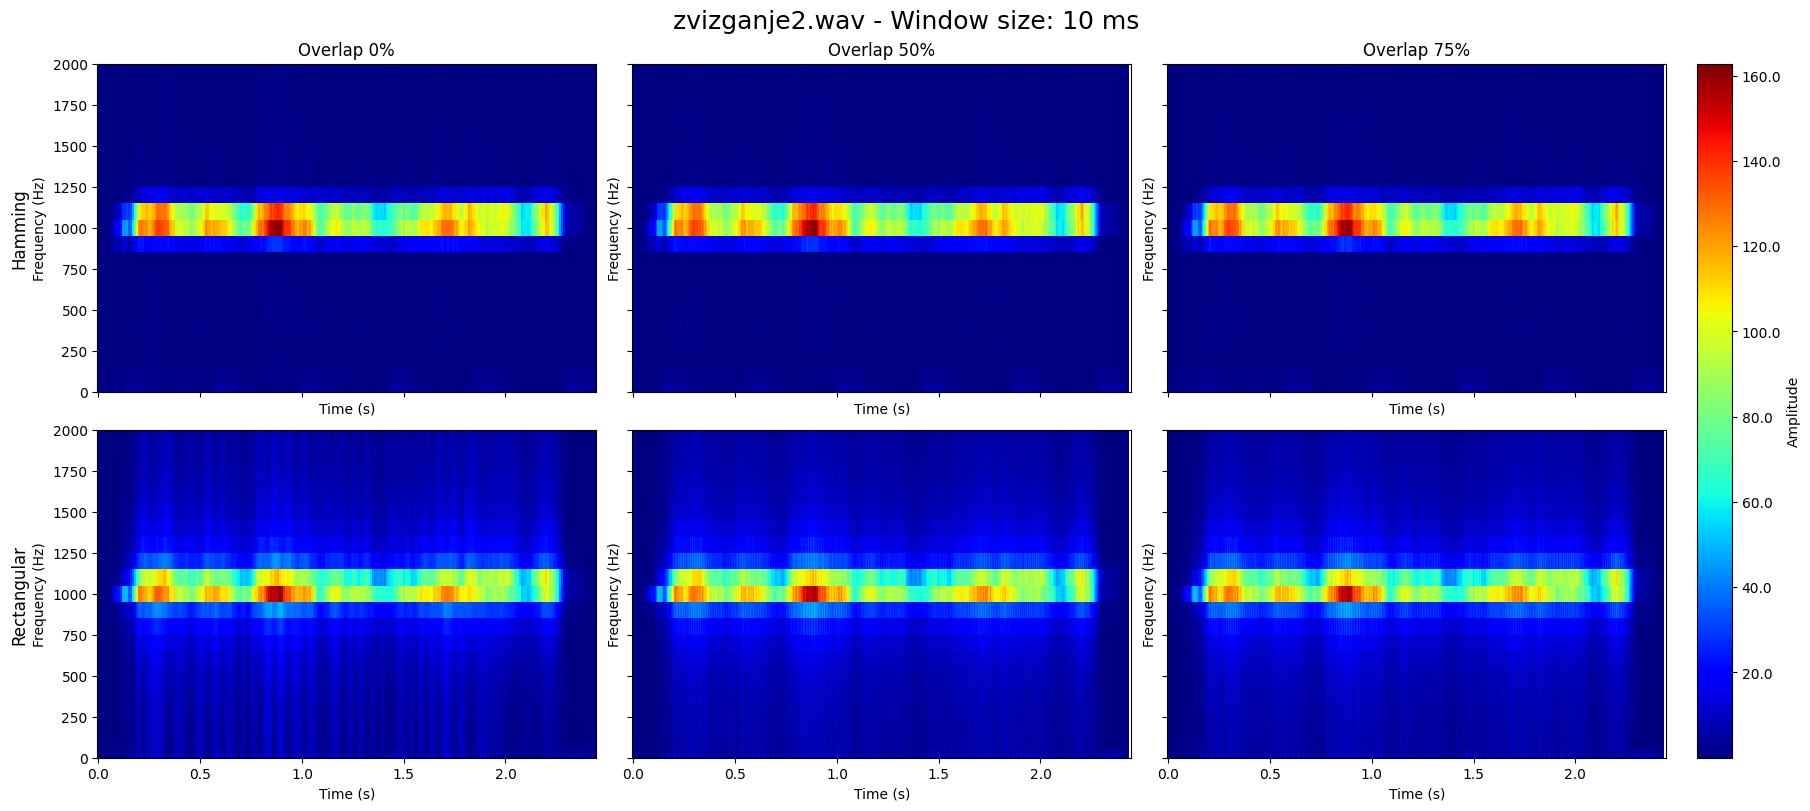

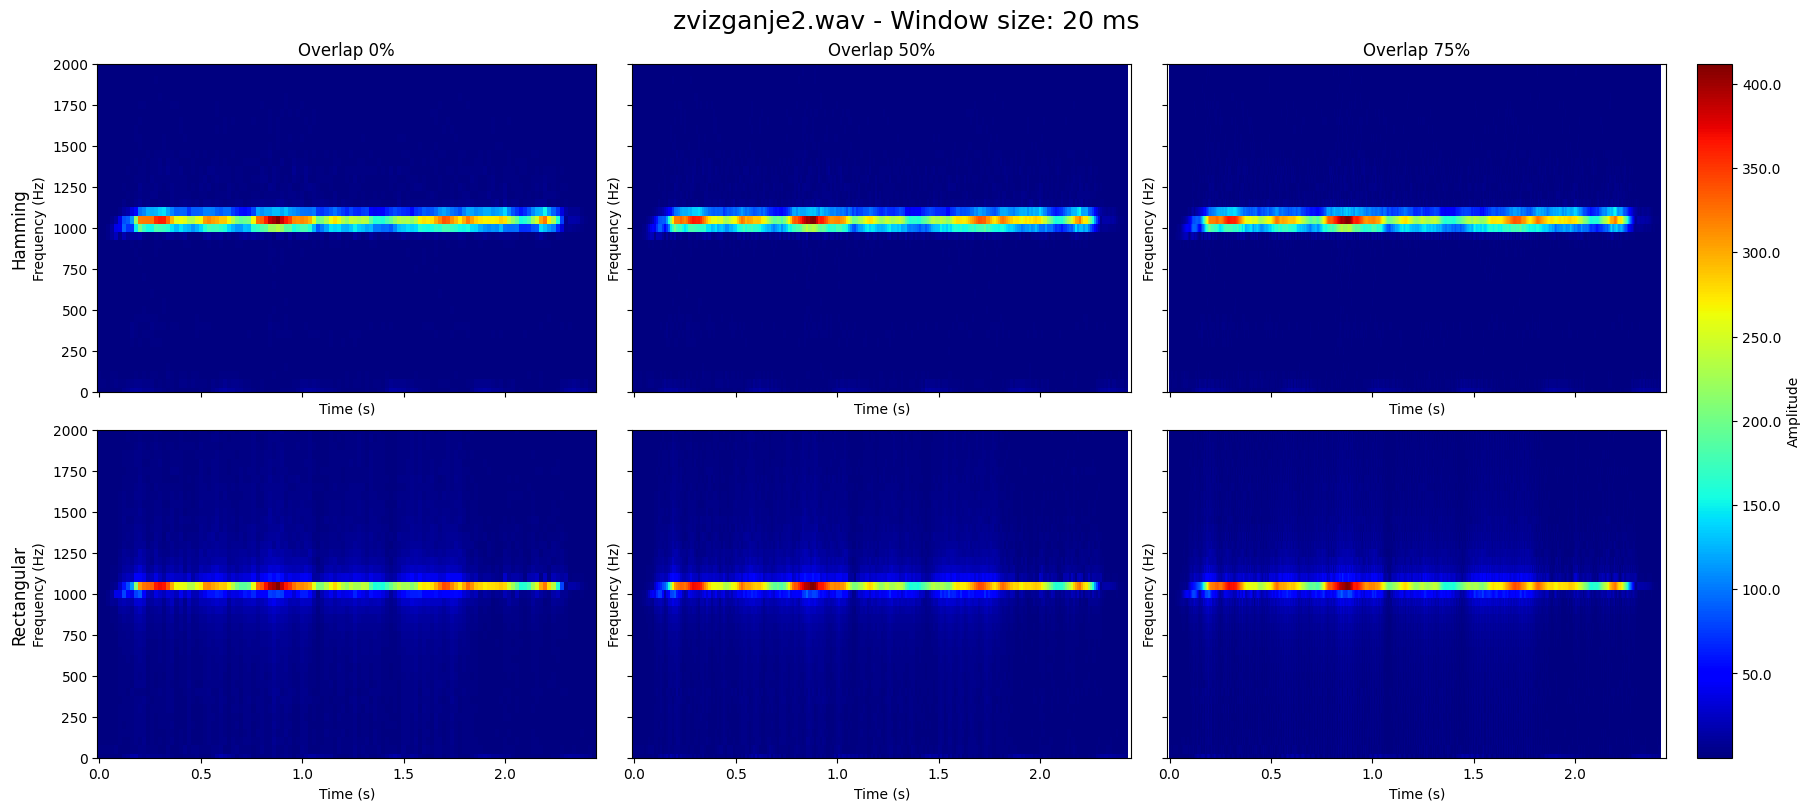

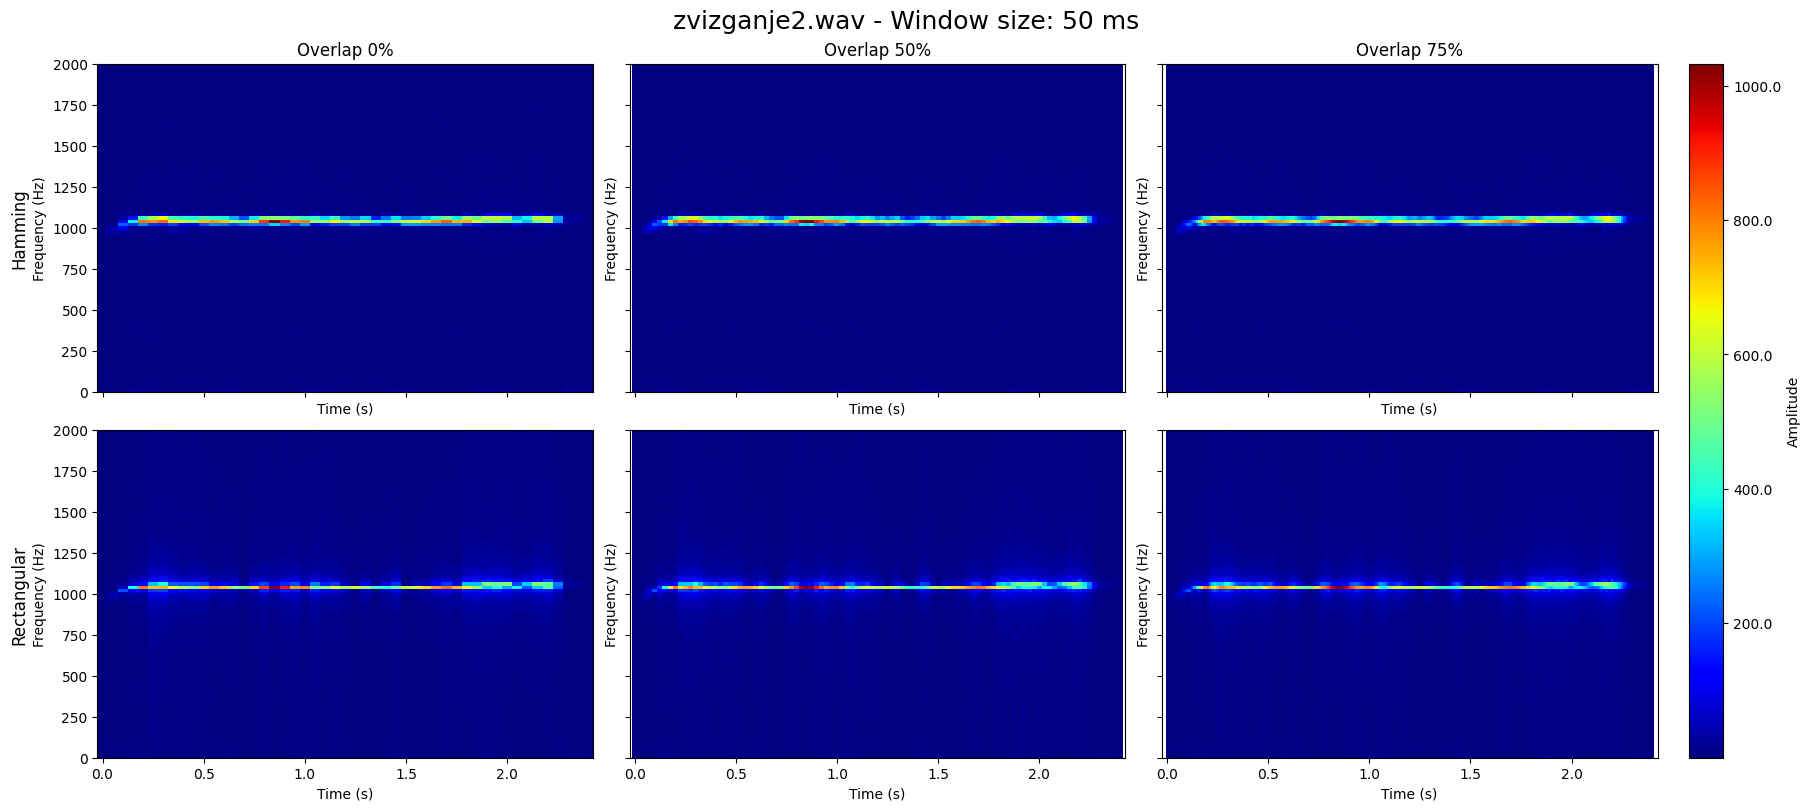

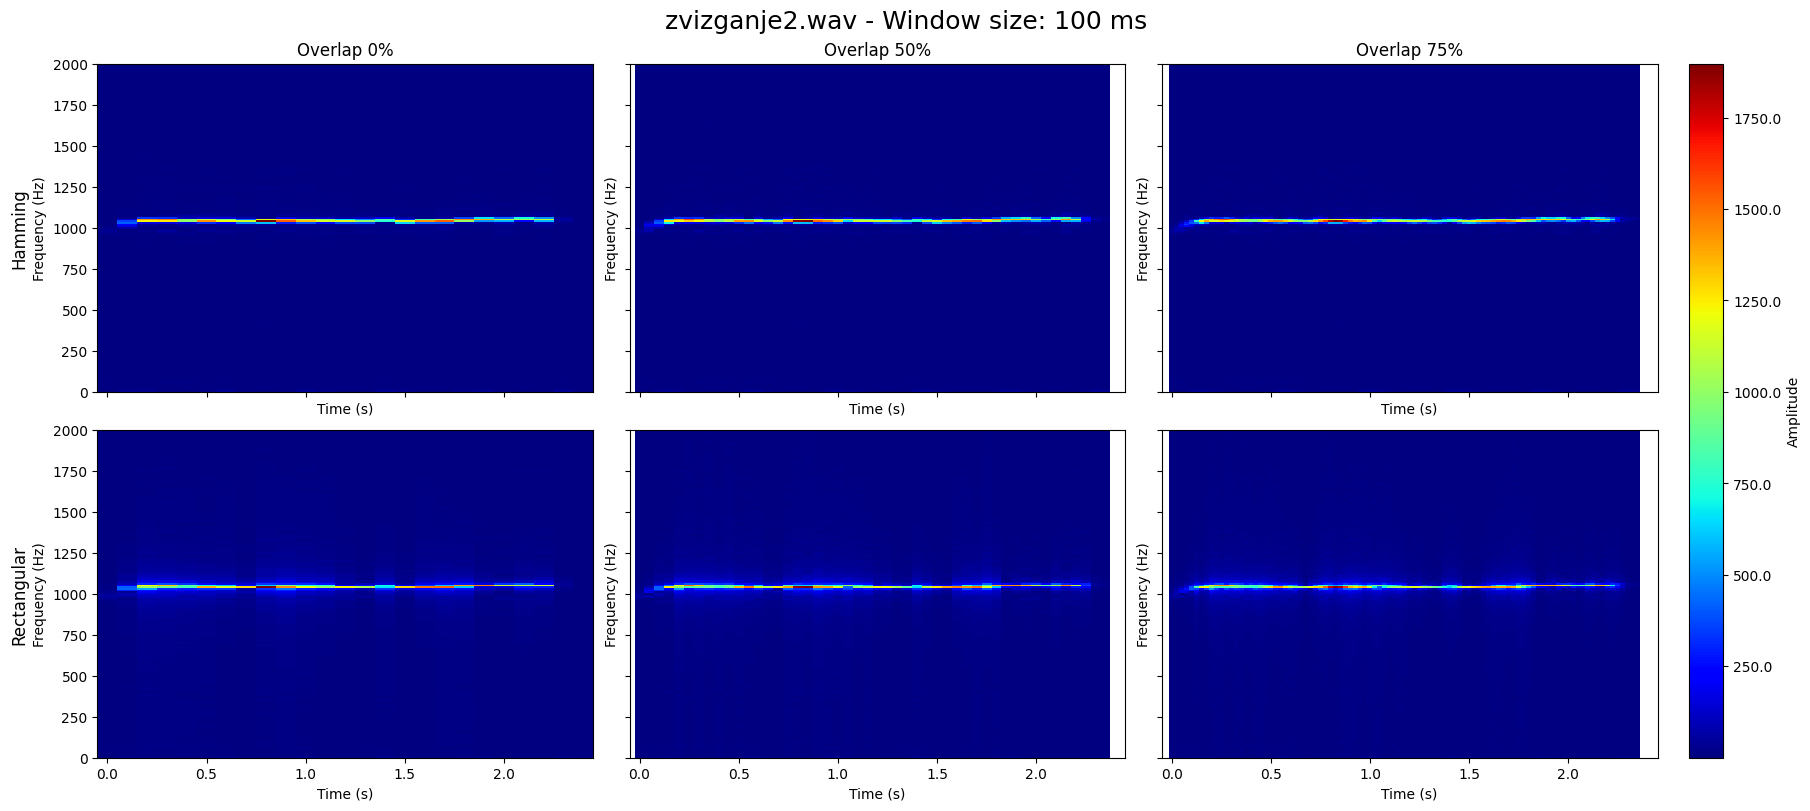

In [5]:
procesiraj_signale()